# Model 8: ConvNeXt-V2 for Depth Regression (Transfer Learning)

---

**Architecture**
- ConvNeXt-V2 Tiny pretrained backbone (from classification model)
- Transfer learning from pose classification task
- Single regression head for depth estimation
- Two-phase training: frozen backbone → full fine-tuning

**Hardware:** Apple M4 + 24GB Unified Memory (MPS)


## 1. Setup & Data Loading

In [1]:
# Standard libraries
import os
import sys
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Subset
from torch.optim.lr_scheduler import CosineAnnealingLR

# Transfer learning library
import timm

# Visualization libraries
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.gridspec import GridSpec
import cv2

# Project modules
project_root = Path(os.getcwd()).parent
sys.path.append(str(project_root))

# Import dataset
from src.data.depth_dataset import RegressDataset

# Import regression utilities
from src.utils.regression_utils import (
    train_epoch_regression,
    validate_epoch_regression,
    collect_predictions_regression,
    compute_regression_metrics,
    RegressionMetricsTracker,
    plot_regression_training_curves,
    plot_predictions_vs_actual,
    plot_residuals,
    plot_error_distribution,
    plot_depth_predictions_gallery,
    load_classification_backbone,
    freeze_backbone,
    unfreeze_backbone
)

# Set device
# Determine the device
if torch.backends.mps.is_available():
    device = torch.device('mps')
elif torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
print(f"Using device: {device}")

# Set seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

print("All libraries and utilities imported successfully")

Using device: mps
All libraries and utilities imported successfully


In [ ]:
# Model prefix for saving files
MODEL_PREFIX = 'convnext_v2_depth'
print(f"Model prefix: {MODEL_PREFIX}")

Model prefix: 8_convnext_v2_depth


### Load Dataset & Create Splits

For regression, we use a simple random split (60/20/20) without stratification.

In [3]:
# Load full dataset
data_root = project_root / 'data'
full_dataset = RegressDataset(rootpath=str(data_root), augment=False)

print(f"Total samples: {len(full_dataset)}")

# Check a sample
sample_img, sample_depth = full_dataset[0]
print(f"\nSample image shape: {sample_img.shape}")
print(f"Sample depth value: {sample_depth.item():.4f}")

Total samples: 2000

Sample image shape: torch.Size([3, 224, 224])
Sample depth value: 0.7850


In [4]:
# Create random splits (60/20/20)
from sklearn.model_selection import train_test_split

# Get all indices
all_indices = list(range(len(full_dataset)))

# First split: 80% train+val, 20% test
train_val_idx, test_idx = train_test_split(
    all_indices,
    test_size=0.2,
    random_state=42
)

# Second split: 75% of train+val becomes train (60% of total), 25% becomes val (20% of total)
train_idx, val_idx = train_test_split(
    train_val_idx,
    test_size=0.25,  # 0.25 of 0.8 = 0.2 of total
    random_state=42
)

print(f"Split sizes:")
print(f"   Train: {len(train_idx)} ({len(train_idx)/len(full_dataset)*100:.1f}%)")
print(f"   Val:   {len(val_idx)} ({len(val_idx)/len(full_dataset)*100:.1f}%)")
print(f"   Test:  {len(test_idx)} ({len(test_idx)/len(full_dataset)*100:.1f}%)")

Split sizes:
   Train: 1200 (60.0%)
   Val:   400 (20.0%)
   Test:  400 (20.0%)


In [5]:
# Verify depth distribution across splits
train_depths = [full_dataset[i][1].item() for i in train_idx]
val_depths = [full_dataset[i][1].item() for i in val_idx]
test_depths = [full_dataset[i][1].item() for i in test_idx]

print("\nDepth Statistics:")
print(f"Train - Min: {min(train_depths):.3f}, Max: {max(train_depths):.3f}, Mean: {np.mean(train_depths):.3f}")
print(f"Val   - Min: {min(val_depths):.3f}, Max: {max(val_depths):.3f}, Mean: {np.mean(val_depths):.3f}")
print(f"Test  - Min: {min(test_depths):.3f}, Max: {max(test_depths):.3f}, Mean: {np.mean(test_depths):.3f}")


Depth Statistics:
Train - Min: 0.000, Max: 1.000, Mean: 0.441
Val   - Min: 0.000, Max: 0.998, Mean: 0.435
Test  - Min: 0.000, Max: 1.000, Mean: 0.457


In [6]:
# Create dataset splits with augmentation for training
train_dataset = RegressDataset(rootpath=str(data_root), augment=True, random_ratio=0.5)
val_dataset = RegressDataset(rootpath=str(data_root), augment=False)
test_dataset = RegressDataset(rootpath=str(data_root), augment=False)

# Create subsets
train_subset = Subset(train_dataset, train_idx)
val_subset = Subset(val_dataset, val_idx)
test_subset = Subset(test_dataset, test_idx)

# Create dataloaders (smaller batch size for ConvNeXt-V2)
batch_size = 16

train_loader = DataLoader(
    train_subset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=0,
    pin_memory=False
)

val_loader = DataLoader(
    val_subset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=0,
    pin_memory=False
)

test_loader = DataLoader(
    test_subset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=0,
    pin_memory=False
)

print("Datasets and loaders created")
print(f"   Train batches: {len(train_loader)}")
print(f"   Val batches: {len(val_loader)}")
print(f"   Test batches: {len(test_loader)}")

Datasets and loaders created
   Train batches: 75
   Val batches: 25
   Test batches: 25


## 2. Model Architecture

**ConvNeXt-V2 for Regression:**
- Uses pretrained ConvNeXt-V2 Tiny as feature extractor
- Feature dimension: 768
- Single regression head outputting continuous depth value
- Transfer learning from classification model trained on pose estimation

In [7]:
class ConvNeXtV2Regression(nn.Module):
    """
    ConvNeXt-V2 for depth regression
    
    Uses pretrained ConvNeXt-V2 Tiny backbone with a single regression head
    for continuous depth value prediction.
    
    Args:
        pretrained: Use pretrained weights from timm
        dropout_rate: Dropout probability in regression head
    """
    
    def __init__(
        self,
        pretrained=True,
        dropout_rate=0.3
    ):
        super(ConvNeXtV2Regression, self).__init__()
        
        # Load pretrained ConvNeXt-V2 Tiny (feature dimension = 768)
        self.backbone = timm.create_model(
            'convnextv2_tiny.fcmae_ft_in1k',
            pretrained=pretrained,
            num_classes=0  # Remove classification head
        )
        
        # Feature dimension from ConvNeXt-V2 Tiny
        self.feature_dim = 768
        
        # Regression head
        self.regression_head = nn.Sequential(
            nn.LayerNorm(self.feature_dim),
            nn.Dropout(dropout_rate),
            nn.Linear(self.feature_dim, 1)
        )
        
        # Initialize regression head
        self._initialize_head()
    
    def _initialize_head(self):
        """Initialize weights for regression head"""
        for m in self.regression_head.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
    
    def forward(self, x, return_features=False):
        """
        Forward pass
        
        Args:
            x: Input tensor of shape (batch_size, 3, H, W)
            return_features: If True, return features along with predictions
        
        Returns:
            depth_out: Depth predictions (batch_size, 1)
            features: (optional) Feature embeddings (batch_size, feature_dim)
        """
        # Extract features using backbone
        features = self.backbone(x)
        
        # Regression output
        depth_out = self.regression_head(features)
        
        if return_features:
            return depth_out, features
        return depth_out
    
    def get_num_params(self):
        return sum(p.numel() for p in self.parameters() if p.requires_grad)

In [8]:
# Test model
test_model = ConvNeXtV2Regression(pretrained=False)
test_input = torch.randn(1, 3, 224, 224)
depth_out = test_model(test_input)

print(f"Model architecture defined")
print(f"   Input shape: {test_input.shape}")
print(f"   Depth output shape: {depth_out.shape}")
print(f"   Total parameters: {test_model.get_num_params():,}")

del test_model, test_input, depth_out

Model architecture defined
   Input shape: torch.Size([1, 3, 224, 224])
   Depth output shape: torch.Size([1, 1])
   Total parameters: 27,868,801


## 3. Transfer Learning Setup

Load pretrained backbone from the classification model and initialize the regression model.

In [ ]:
# Path to classification model checkpoint
classification_model_path = project_root / 'models' / '3_convnextv2_poset.pth'

# Check if classification model exists
if not classification_model_path.exists():
    print(f"WARNING: Classification model not found at {classification_model_path}")
    print("Will use ImageNet pretrained weights instead")
    use_classification_weights = False
else:
    print(f"Classification model found at {classification_model_path}")
    use_classification_weights = True

Classification model found at /Users/adgodoyo/Library/CloudStorage/OneDrive-UniversidadNacionaldeColombia/Textos y Trabajos/Academic Imperial/Deep Learning/Final Assignment/mycode/models/convnextv2_baseline_best.pth


In [10]:
# Initialize regression model
model = ConvNeXtV2Regression(
    pretrained=True,  # Start with ImageNet weights
    dropout_rate=0.3
).to(device)

print(f"Regression model initialized")
print(f"   Total parameters: {model.get_num_params():,}")

# Load classification backbone if available
if use_classification_weights:
    print(f"\nLoading classification backbone weights...")
    model = load_classification_backbone(
        classification_model_path=str(classification_model_path),
        regression_model=model,
        device=device,
        strict=False
    )
    print("Classification backbone loaded successfully")
else:
    print("\nUsing ImageNet pretrained weights only")

Regression model initialized
   Total parameters: 27,868,801

Loading classification backbone weights...
Loaded 198/202 layers from classification model
Classification backbone loaded successfully


## 4. Phase 1: Frozen Backbone Training

First, we train only the regression head while keeping the backbone frozen. This allows the new regression head to adapt to the depth estimation task without disrupting the pretrained features.

In [ ]:
# Freeze backbone for phase 1
print("Phase 1: Freezing backbone, training regression head only\n")
model = freeze_backbone(model)

# Loss function
criterion = nn.MSELoss()

# Optimizer (only for regression head)
optimizer_phase1 = torch.optim.AdamW(
    filter(lambda p: p.requires_grad, model.parameters()),
    lr=1e-3,
    weight_decay=1e-4
)

# Learning rate scheduler
scheduler_phase1 = CosineAnnealingLR(
    optimizer_phase1,
    T_max=30,
    eta_min=1e-6
)

# Metrics tracker
tracker_phase1 = RegressionMetricsTracker()

print(f"Optimizer: AdamW (lr=1e-3, weight_decay=1e-4)")
print(f"Scheduler: CosineAnnealingLR (T_max=30)")
print(f"Criterion: MSELoss")

Phase 1: Freezing backbone, training regression head only

Frozen parameters: 1,953,312
Trainable parameters: 25,915,489
Optimizer: AdamW (lr=1e-3, weight_decay=1e-4)
Scheduler: CosineAnnealingLR (T_max=30)
Criterion: MSELoss


In [13]:
# Training configuration for phase 1
num_epochs_phase1 = 30
best_val_loss_phase1 = float('inf')

print(f"Starting Phase 1 training for {num_epochs_phase1} epochs...")
print(f"Training only regression head (backbone frozen)\n")

for epoch in range(num_epochs_phase1):
    # Train
    train_metrics = train_epoch_regression(
        model=model,
        dataloader=train_loader,
        criterion=criterion,
        optimizer=optimizer_phase1,
        device=device
    )
    
    # Validate
    val_metrics = validate_epoch_regression(
        model=model,
        dataloader=val_loader,
        criterion=criterion,
        device=device
    )
    
    # Update learning rate
    scheduler_phase1.step()
    current_lr = optimizer_phase1.param_groups[0]['lr']
    
    # Update tracker
    tracker_phase1.update({
        'train_loss': train_metrics['loss'],
        'train_rmse': train_metrics['rmse'],
        'train_mae': train_metrics['mae'],
        'val_loss': val_metrics['loss'],
        'val_rmse': val_metrics['rmse'],
        'val_mae': val_metrics['mae'],
        'lr': current_lr
    })
    
    # Print progress
    if (epoch + 1) % 5 == 0 or epoch == 0:
        print(f"Epoch [{epoch+1}/{num_epochs_phase1}]")
        print(f"  Train - Loss: {train_metrics['loss']:.4f}, RMSE: {train_metrics['rmse']:.4f}, MAE: {train_metrics['mae']:.4f}")
        print(f"  Val   - Loss: {val_metrics['loss']:.4f}, RMSE: {val_metrics['rmse']:.4f}, MAE: {val_metrics['mae']:.4f}")
        print(f"  LR: {current_lr:.6f}")
    
    # Save best model
    if val_metrics['loss'] < best_val_loss_phase1:
        best_val_loss_phase1 = val_metrics['loss']
        best_model_state_phase1 = model.state_dict()
        print(f"  -> New best validation loss: {best_val_loss_phase1:.4f}")

print(f"\nPhase 1 training completed!")
print(f"Best validation loss: {best_val_loss_phase1:.4f}")

# Load best model from phase 1
model.load_state_dict(best_model_state_phase1)

Starting Phase 1 training for 30 epochs...
Training only regression head (backbone frozen)

Epoch [1/30]
  Train - Loss: 0.0023, RMSE: 0.0478, MAE: 0.0368
  Val   - Loss: 0.0020, RMSE: 0.0442, MAE: 0.0319
  LR: 0.000004
  -> New best validation loss: 0.0020
  -> New best validation loss: 0.0020
Epoch [5/30]
  Train - Loss: 0.0025, RMSE: 0.0496, MAE: 0.0384
  Val   - Loss: 0.0027, RMSE: 0.0516, MAE: 0.0382
  LR: 0.000068
Epoch [10/30]
  Train - Loss: 0.0027, RMSE: 0.0520, MAE: 0.0411
  Val   - Loss: 0.0019, RMSE: 0.0441, MAE: 0.0323
  LR: 0.000251
  -> New best validation loss: 0.0019
Epoch [15/30]
  Train - Loss: 0.0045, RMSE: 0.0673, MAE: 0.0525
  Val   - Loss: 0.0021, RMSE: 0.0454, MAE: 0.0332
  LR: 0.000501
Epoch [20/30]
  Train - Loss: 0.0109, RMSE: 0.1043, MAE: 0.0853
  Val   - Loss: 0.0033, RMSE: 0.0576, MAE: 0.0434
  LR: 0.000750
Epoch [25/30]
  Train - Loss: 0.0064, RMSE: 0.0803, MAE: 0.0648
  Val   - Loss: 0.0050, RMSE: 0.0707, MAE: 0.0583
  LR: 0.000933
  -> New best validati

<All keys matched successfully>

In [ ]:
# Save phase 1 model
models_dir = project_root / 'models'
models_dir.mkdir(exist_ok=True)

phase1_model_path = models_dir / f'7_{MODEL_PREFIX}_backboneFR.pth'
torch.save({
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer_phase1.state_dict(),
    'best_val_loss': best_val_loss_phase1,
    'tracker_history': tracker_phase1.get_history()
}, phase1_model_path)

print(f"Phase 1 model saved to: {phase1_model_path}")

Phase 1 model saved to: /Users/adgodoyo/Library/CloudStorage/OneDrive-UniversidadNacionaldeColombia/Textos y Trabajos/Academic Imperial/Deep Learning/Final Assignment/mycode/models/8_convnext_v2_depth_backboneFR.pth


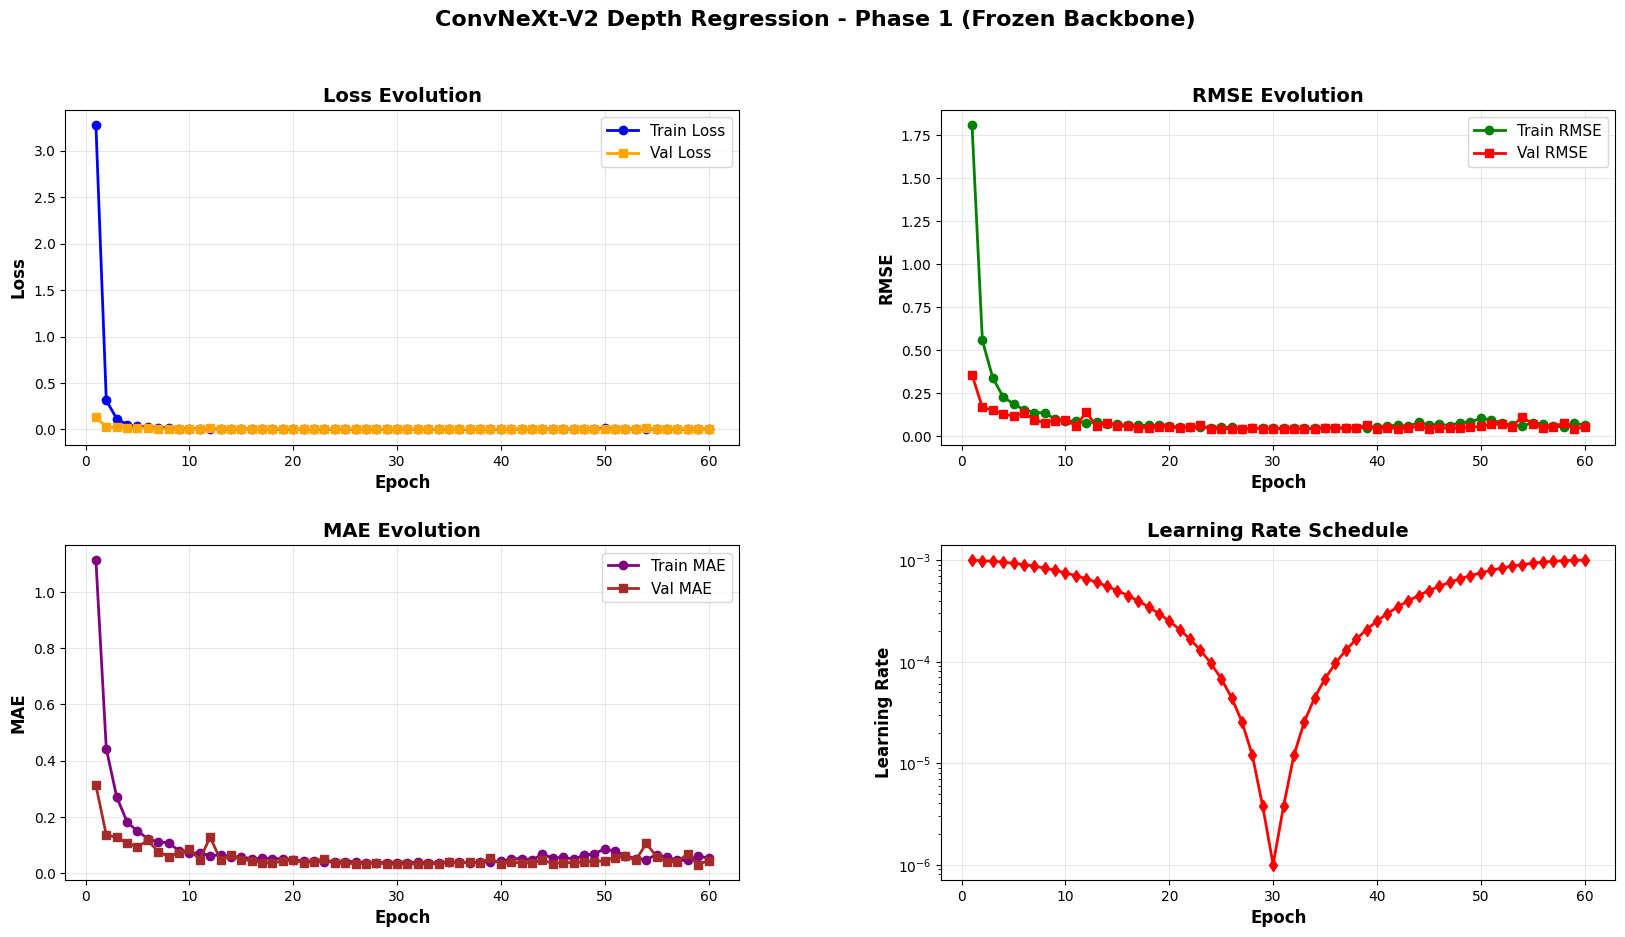

In [14]:
# Plot phase 1 training curves
reports_dir = project_root / 'reports'
reports_dir.mkdir(exist_ok=True)

plot_regression_training_curves(
    tracker_history=tracker_phase1.get_history(),
    save_path=reports_dir / '8_convnext_v2_depth_phase1_training_curves.png',
    title='ConvNeXt-V2 Depth Regression - Phase 1 (Frozen Backbone)'
)

## 5. Phase 2: Full Fine-tuning (Unfrozen Backbone)

Now we unfreeze all layers and fine-tune the entire model with a much lower learning rate. This allows the backbone to adapt specifically to the depth estimation task.

In [12]:
# Unfreeze all layers for full fine-tuning
from src.utils.regression_utils import unfreeze_backbone
model = unfreeze_backbone(model)

# Phase 2 configuration (much lower learning rate)
PHASE2_CONFIG = {
    'epochs': 130,
    'lr': 1e-05,  # ConvNeXt-V2: 1e-05
    'weight_decay': 1e-4,
    'patience': 15
}

# Reinitialize optimizer and scheduler for phase 2
optimizer_phase2 = torch.optim.AdamW(
    model.parameters(),
    lr=PHASE2_CONFIG['lr'],
    weight_decay=PHASE2_CONFIG['weight_decay']
)

scheduler_phase2 = torch.optim.lr_scheduler.CosineAnnealingLR(
    optimizer_phase2,
    T_max=PHASE2_CONFIG['epochs'],
    eta_min=1e-7
)

# New tracker for phase 2
phase2_tracker = RegressionMetricsTracker()

print(f"Phase 2 Configuration:")
print(f"  Epochs: {PHASE2_CONFIG['epochs']}")
print(f"  Learning rate: {PHASE2_CONFIG['lr']}")
print(f"  Weight decay: {PHASE2_CONFIG['weight_decay']}")
print(f"  Early stopping patience: {PHASE2_CONFIG['patience']}")

Trainable parameters: 27,868,801/27,868,801
Phase 2 Configuration:
  Epochs: 130
  Learning rate: 1e-05
  Weight decay: 0.0001
  Early stopping patience: 15


In [13]:
# Phase 2 training loop
best_val_rmse_phase2 = float('inf')
best_model_state_phase2 = None
patience_counter = 10

print(f"Starting Phase 2 training for {PHASE2_CONFIG['epochs']} epochs...\n")

for epoch in range(1, PHASE2_CONFIG['epochs'] + 1):
    # Train
    train_metrics = train_epoch_regression(
        model, train_loader, criterion, optimizer_phase2, device
    )
    
    # Validate
    val_metrics = validate_epoch_regression(
        model, val_loader, criterion, device
    )
    
    # Update tracker
    phase2_tracker.update({
        'train_loss': train_metrics['loss'],
        'train_rmse': train_metrics['rmse'],
        'train_mae': train_metrics['mae'],
        'val_loss': val_metrics['loss'],
        'val_rmse': val_metrics['rmse'],
        'val_mae': val_metrics['mae'],
        'lr': optimizer_phase2.param_groups[0]['lr']
    })
    
    # Print progress
    if epoch % 5 == 0 or epoch == 1:
        print(f"Epoch {epoch}/{PHASE2_CONFIG['epochs']}")
        print(f"  Train - Loss: {train_metrics['loss']:.6f} | RMSE: {train_metrics['rmse']:.6f}")
        print(f"  Val   - Loss: {val_metrics['loss']:.6f} | RMSE: {val_metrics['rmse']:.6f}")
    
    # Early stopping
    if val_metrics['rmse'] < best_val_rmse_phase2:
        best_val_rmse_phase2 = val_metrics['rmse']
        best_model_state_phase2 = model.state_dict().copy()
        patience_counter = 0
        print(f"  -> New best val RMSE: {best_val_rmse_phase2:.6f}")
    else:
        patience_counter += 1
        if patience_counter >= PHASE2_CONFIG['patience']:
            print(f"\nEarly stopping at epoch {epoch}")
            break
    
    scheduler_phase2.step()

print(f"\nPhase 2 complete. Best val RMSE: {best_val_rmse_phase2:.6f}")



Starting Phase 2 training for 130 epochs...

Epoch 1/130
  Train - Loss: 1.256836 | RMSE: 1.121087
  Val   - Loss: 0.187722 | RMSE: 0.433269
  -> New best val RMSE: 0.433269
  -> New best val RMSE: 0.423696
  -> New best val RMSE: 0.360895
  -> New best val RMSE: 0.333505
Epoch 5/130
  Train - Loss: 0.894180 | RMSE: 0.945611
  Val   - Loss: 0.151316 | RMSE: 0.388994
  -> New best val RMSE: 0.321675
  -> New best val RMSE: 0.307474
Epoch 10/130
  Train - Loss: 0.766989 | RMSE: 0.875779
  Val   - Loss: 0.063769 | RMSE: 0.252526
  -> New best val RMSE: 0.252526
  -> New best val RMSE: 0.246577
Epoch 15/130
  Train - Loss: 0.567868 | RMSE: 0.753570
  Val   - Loss: 0.053649 | RMSE: 0.231623
  -> New best val RMSE: 0.231623
  -> New best val RMSE: 0.182924
  -> New best val RMSE: 0.162210
Epoch 20/130
  Train - Loss: 0.275447 | RMSE: 0.524831
  Val   - Loss: 0.024677 | RMSE: 0.157088
  -> New best val RMSE: 0.157088
  -> New best val RMSE: 0.151582
  -> New best val RMSE: 0.135514
Epoch 25/1

In [ ]:
# Load best model and save
if best_model_state_phase2 is not None:
    model.load_state_dict(best_model_state_phase2)
    phase2_model_path = project_root / "models" / f'8_{MODEL_PREFIX}_Unfrozen.pth'
    torch.save({
        'model_state_dict': best_model_state_phase2,
        'optimizer_state_dict': optimizer_phase2.state_dict(),
        'best_val_rmse': best_val_rmse_phase2,
        'tracker_history': phase2_tracker.get_history()
    }, phase2_model_path)
    print(f"Phase 2 model saved to: {phase2_model_path}")

Phase 2 model saved to: /Users/adgodoyo/Library/CloudStorage/OneDrive-UniversidadNacionaldeColombia/Textos y Trabajos/Academic Imperial/Deep Learning/Final Assignment/mycode/models/8_convnext_v2_depth_Unfrozen.pth


## 6. Model Selection

Compare Phase 1 (frozen backbone) vs Phase 2 (full fine-tuning) to understand 
the impact of fine-tuning on depth estimation performance.

In [11]:
SELECTED_MODEL = 'Unfrozen'

In [14]:
# -----------------------------
# Load the model checkpoint
# -----------------------------
model_path = project_root / "models" / f"8_convnext_v2_depth_{SELECTED_MODEL}.pth"

model = ConvNeXtV2Regression(
    pretrained=False,
    dropout_rate=0.2      # <- MUST match training
).to(device)

checkpoint = torch.load(
    model_path,
    map_location=device,
    weights_only=False     # <- REQUIRED in PyTorch 2.6+
)

model.load_state_dict(checkpoint["model_state_dict"])
model.eval()

ConvNeXtV2Regression(
  (backbone): ConvNeXt(
    (stem): Sequential(
      (0): Conv2d(3, 96, kernel_size=(4, 4), stride=(4, 4))
      (1): LayerNorm2d((96,), eps=1e-06, elementwise_affine=True)
    )
    (stages): Sequential(
      (0): ConvNeXtStage(
        (downsample): Identity()
        (blocks): Sequential(
          (0): ConvNeXtBlock(
            (conv_dw): Conv2d(96, 96, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=96)
            (norm): LayerNorm((96,), eps=1e-06, elementwise_affine=True)
            (mlp): GlobalResponseNormMlp(
              (fc1): Linear(in_features=96, out_features=384, bias=True)
              (act): GELU()
              (drop1): Dropout(p=0.0, inplace=False)
              (grn): GlobalResponseNorm()
              (fc2): Linear(in_features=384, out_features=96, bias=True)
              (drop2): Dropout(p=0.0, inplace=False)
            )
            (shortcut): Identity()
            (drop_path): Identity()
          )
          (1): Conv

## 7. Evaluation & Analysis

Comprehensive evaluation of the selected model on the test set.

### 6.2 Test Set Evaluation

In [30]:
# Collect predictions on test set
test_results = collect_predictions_regression(
    model=model,
    dataloader=test_loader,
    device=device,
    return_images=True
)

print("Test set predictions collected")
print(f"   Predictions shape: {test_results['predictions'].shape}")
print(f"   Targets shape: {test_results['targets'].shape}")
print(f"   Images shape: {test_results['images'].shape}")

Test set predictions collected
   Predictions shape: (400,)
   Targets shape: (400,)
   Images shape: (400, 3, 224, 224)


In [31]:
# Compute comprehensive metrics
test_metrics = compute_regression_metrics(
    predictions=test_results['predictions'],
    targets=test_results['targets']
)

print("\nTest Set Performance:")
print("="*50)
print(f"MSE:           {test_metrics['mse']:.6f}")
print(f"RMSE:          {test_metrics['rmse']:.6f}")
print(f"MAE:           {test_metrics['mae']:.6f}")
print(f"Median AE:     {test_metrics['median_ae']:.6f}")
print(f"R²:            {test_metrics['r2']:.6f}")
print(f"Max Error:     {test_metrics['max_error']:.6f}")
print(f"Std Error:     {test_metrics['std_error']:.6f}")
if 'mape' in test_metrics:
    print(f"MAPE:          {test_metrics['mape']:.2f}%")
print("="*50)


Test Set Performance:
MSE:           0.001741
RMSE:          0.041731
MAE:           0.032083
Median AE:     0.025935
R²:            0.982617
Max Error:     0.165745
Std Error:     0.041729


### 8.2 Predictions vs Actual Scatter Plot

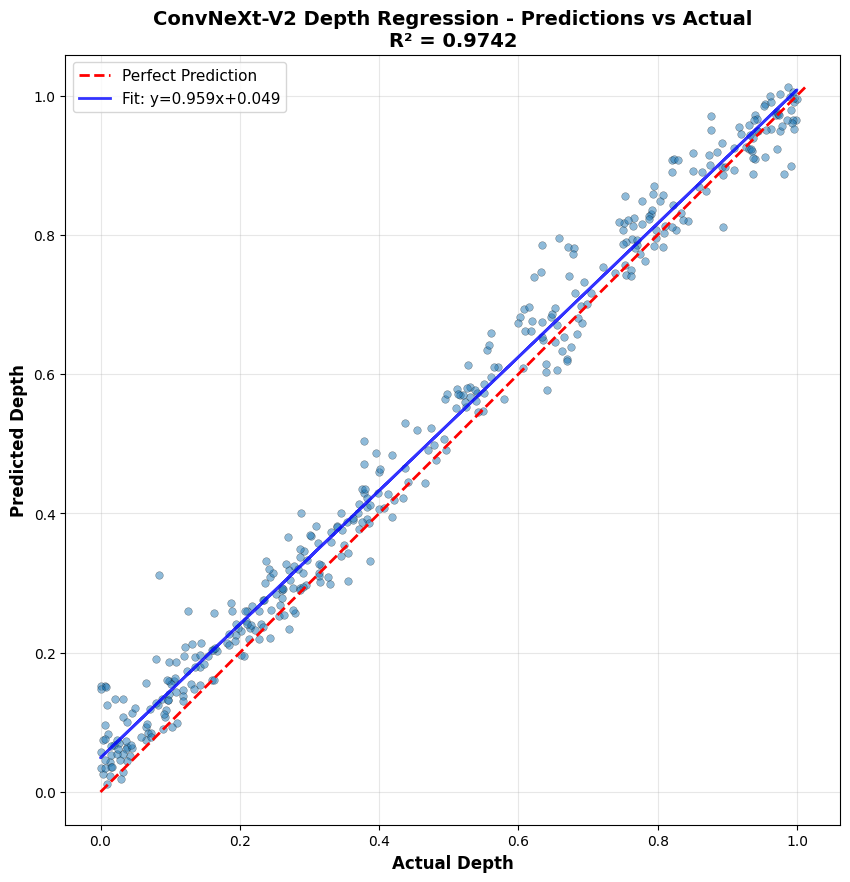

In [17]:
plot_predictions_vs_actual(
    predictions=test_results['predictions'],
    targets=test_results['targets'],
    save_path=reports_dir / f'{MODEL_PREFIX}_final_predictions_vs_actual.png',
    title=f'{final_model_name} - Predictions vs Actual'
)

### 8.3 Residual Analysis

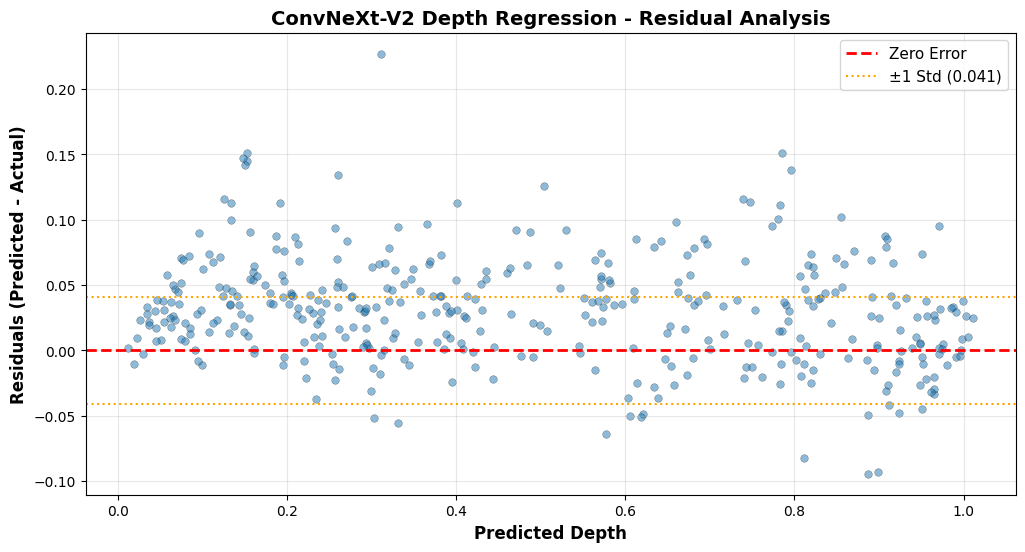

In [18]:
plot_residuals(
    predictions=test_results['predictions'],
    targets=test_results['targets'],
    save_path=reports_dir / f'{MODEL_PREFIX}_final_residuals.png',
    title=f'{final_model_name} - Residual Analysis'
)

### 8.4 Error Distribution

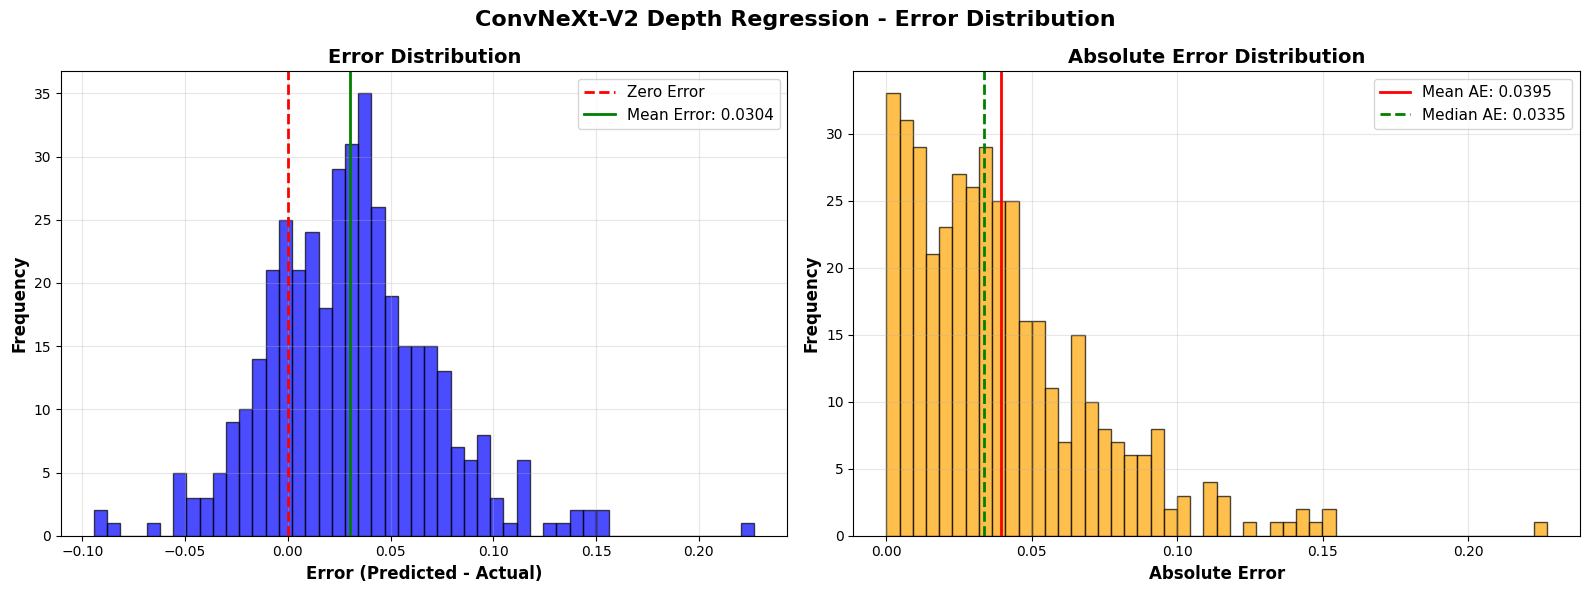

In [19]:
plot_error_distribution(
    predictions=test_results['predictions'],
    targets=test_results['targets'],
    save_path=reports_dir / f'{MODEL_PREFIX}_final_error_distribution.png',
    title=f'{final_model_name} - Error Distribution'
)

## 8. Advanced Visualizations

Comprehensive visual analysis of the selected model.

### 8.1 Depth Predictions Gallery

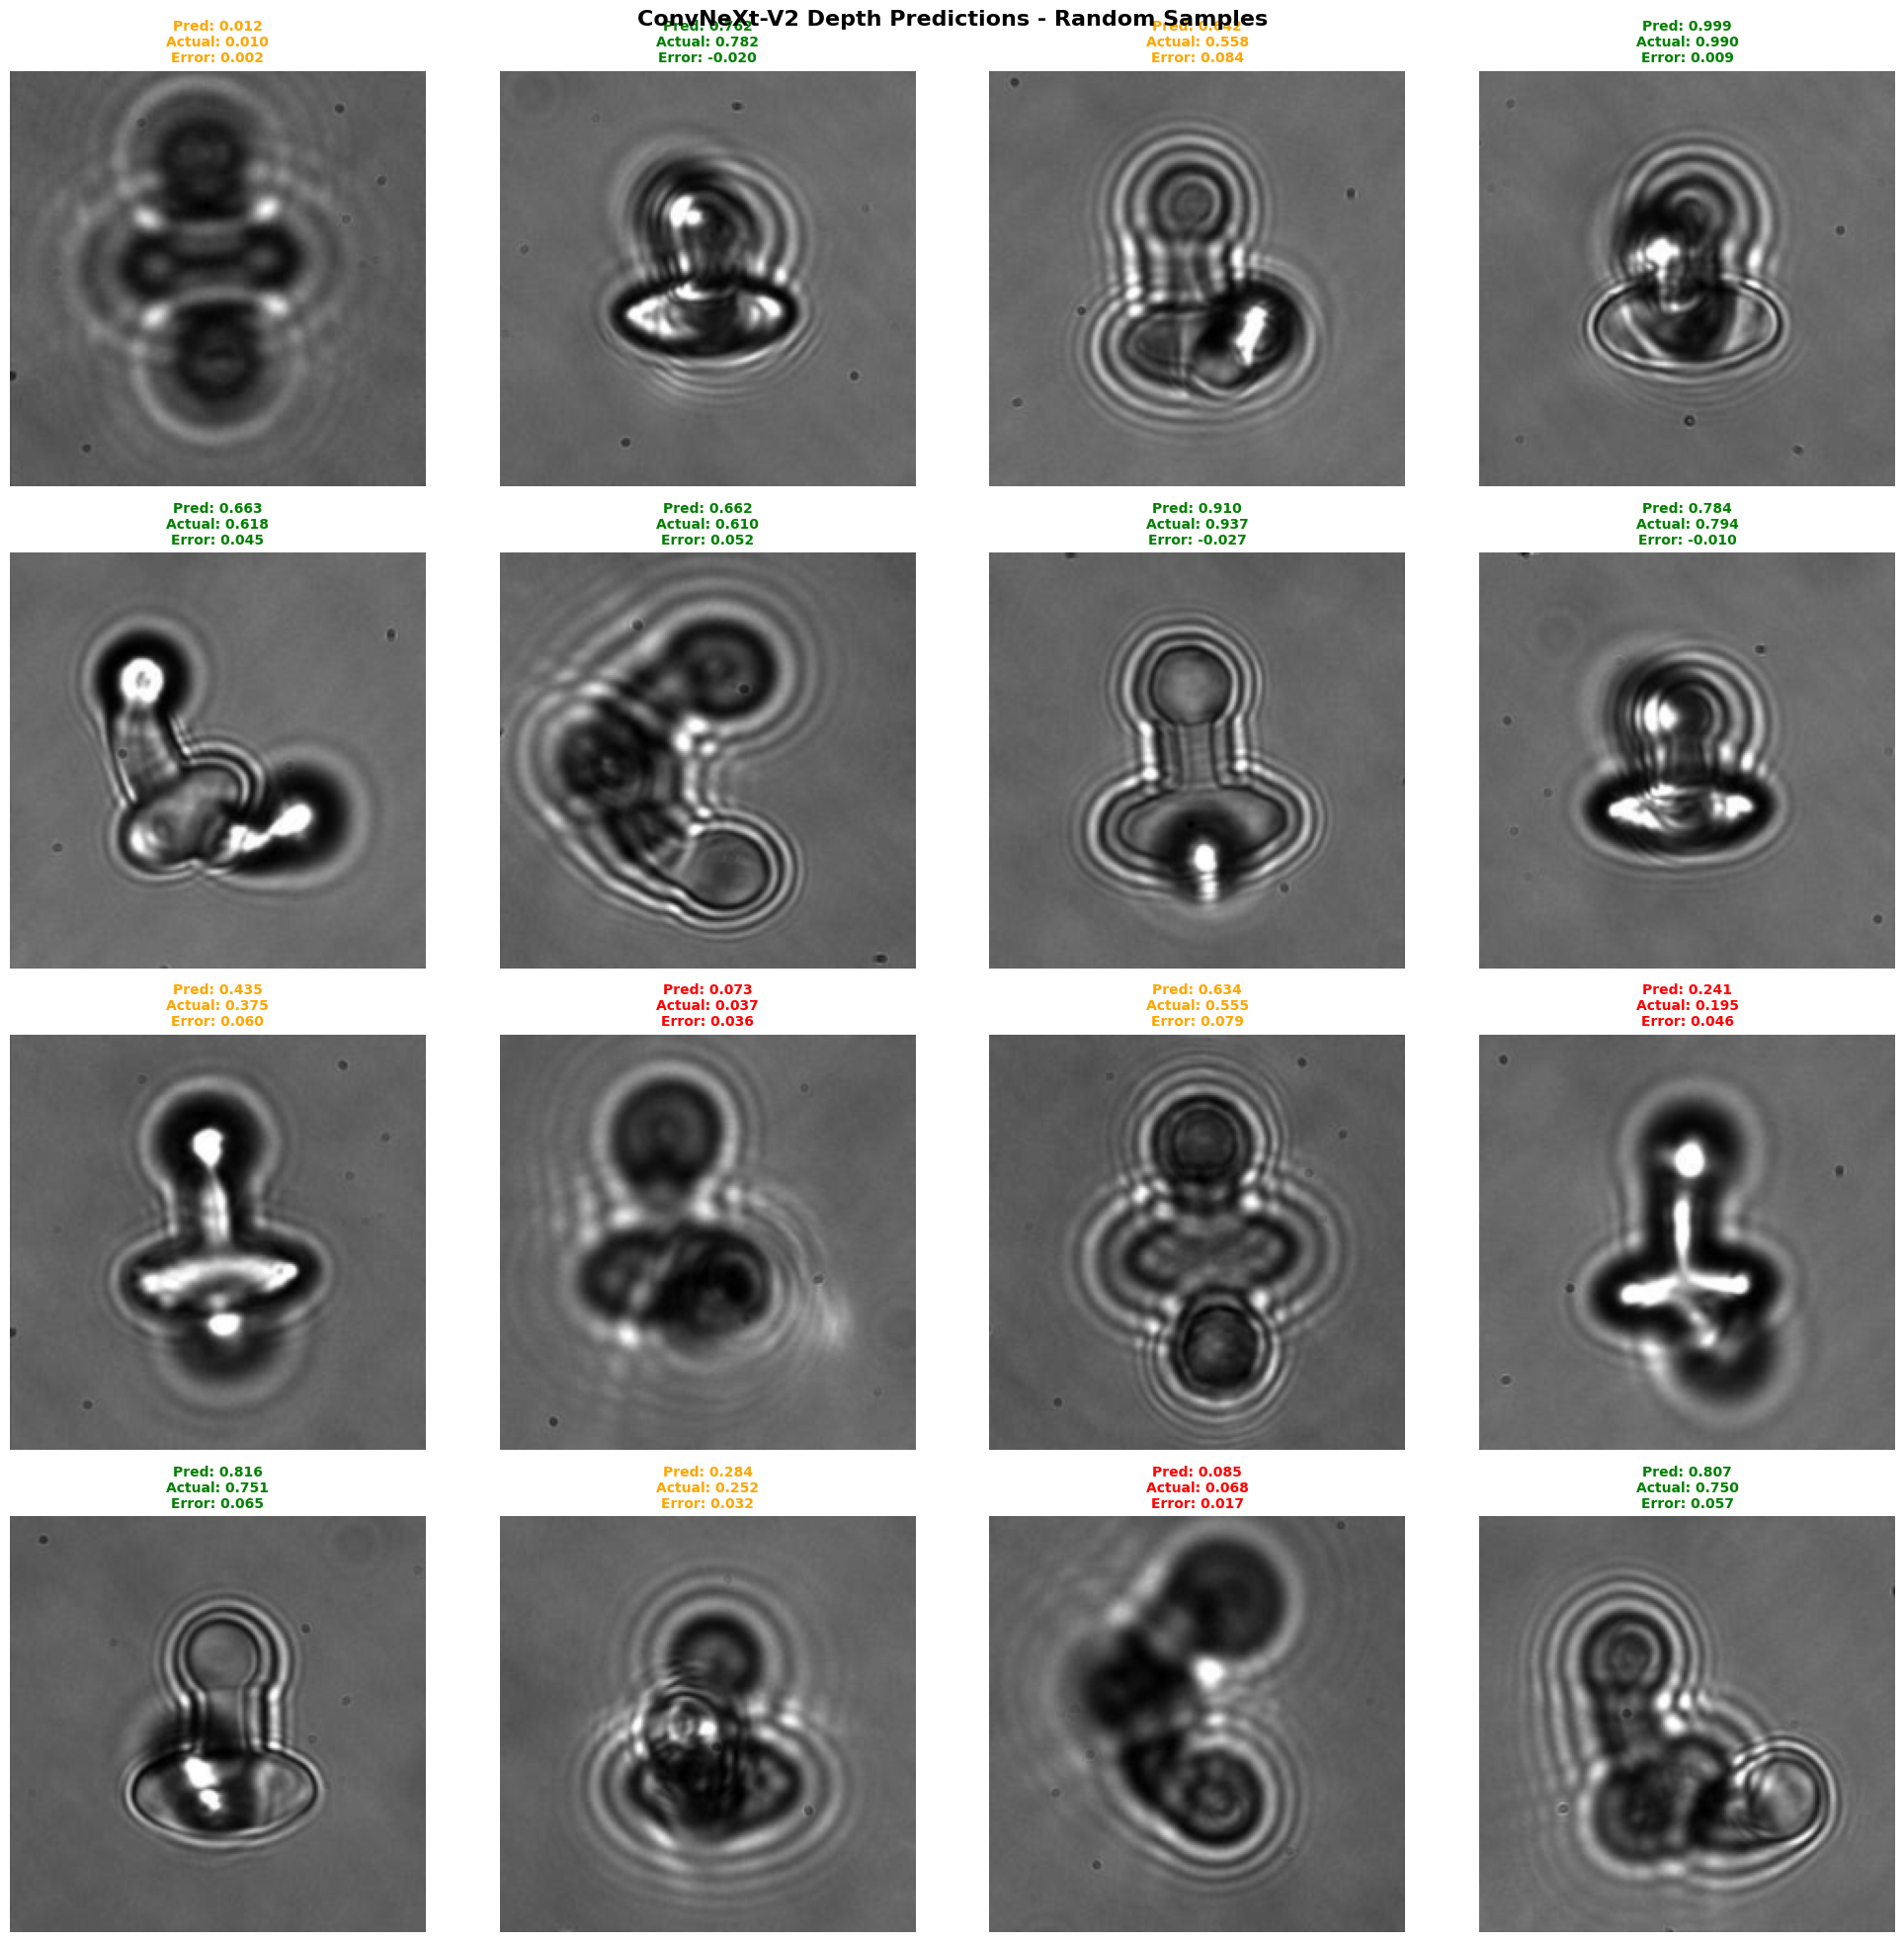

In [20]:
# Random sample of predictions
plot_depth_predictions_gallery(
    images=test_results['images'],
    predictions=test_results['predictions'],
    targets=test_results['targets'],
    num_samples=16,
    save_path=reports_dir / f'{MODEL_PREFIX}_final_predictions_gallery.png',
    title=f'{final_model_name} - Predictions Gallery'
)

### 8.2 Best and Worst Predictions

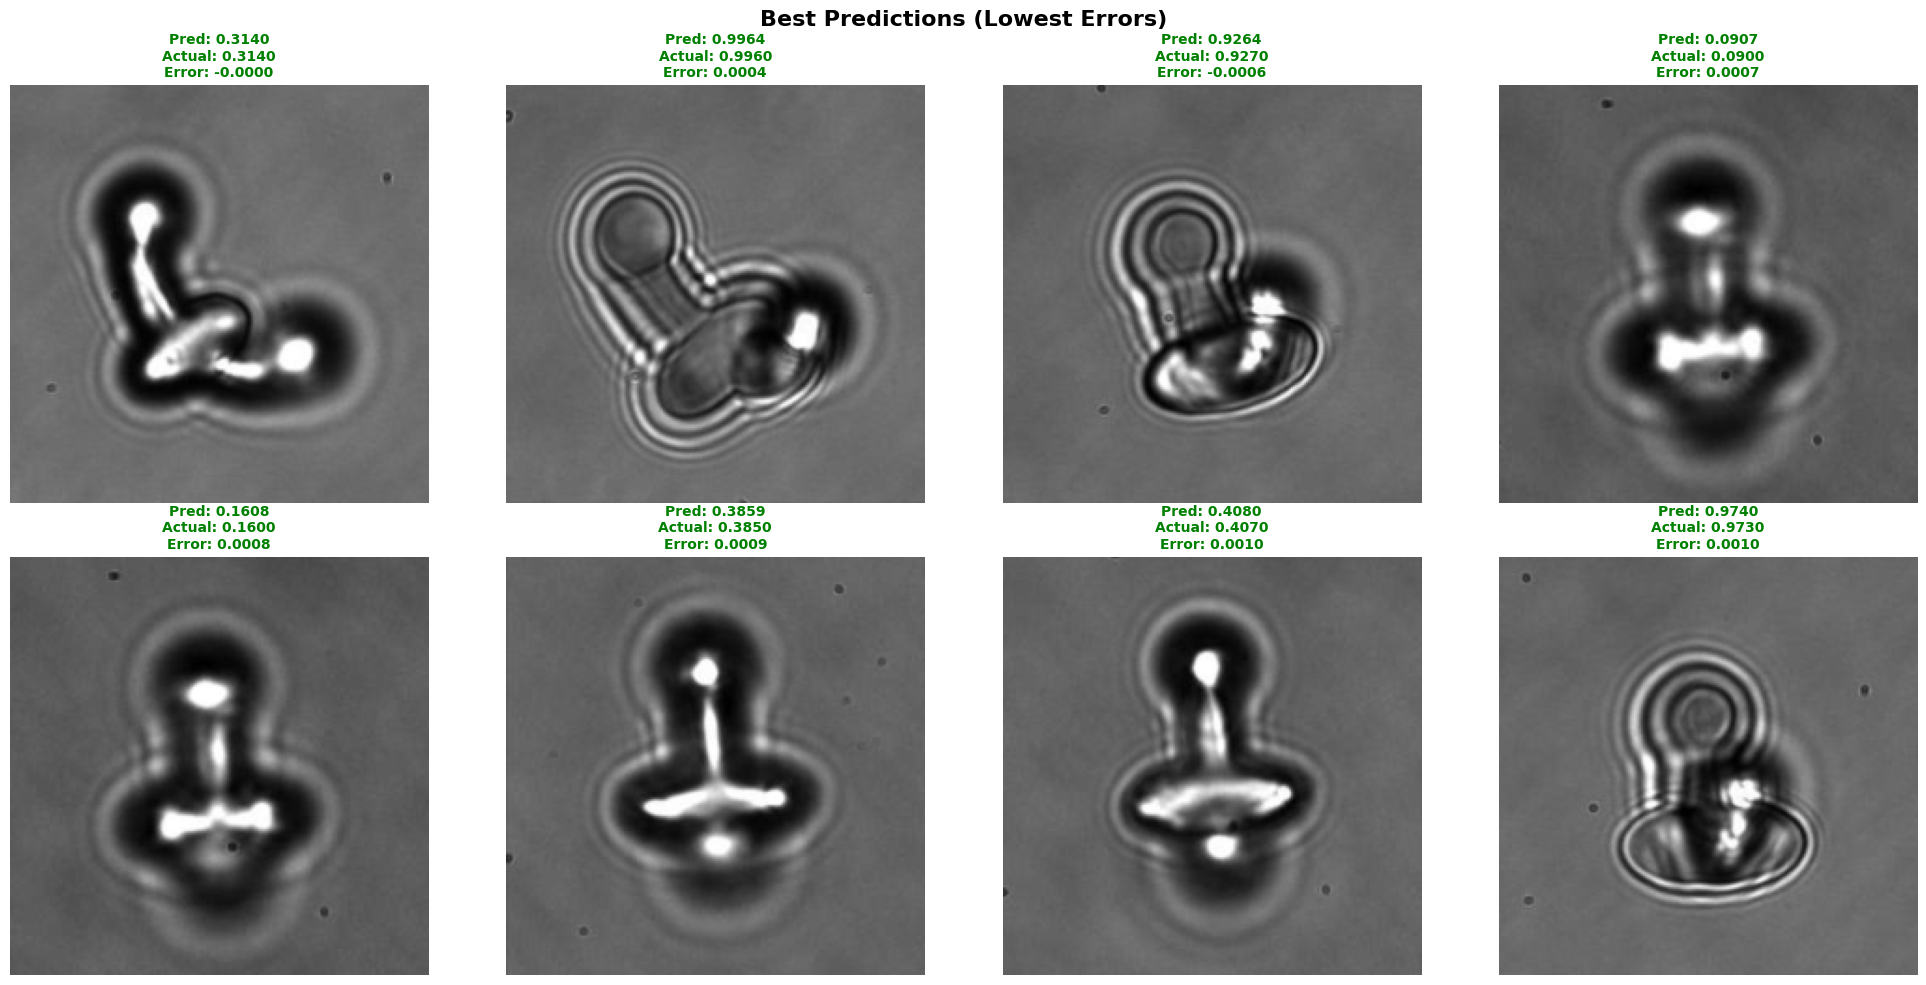

In [21]:
# Find best and worst predictions
errors = np.abs(test_results['predictions'] - test_results['targets'])
best_indices = np.argsort(errors)[:8]
worst_indices = np.argsort(errors)[-8:]

# Visualize best predictions
fig, axes = plt.subplots(2, 4, figsize=(20, 10))
axes = axes.flatten()

for i, idx in enumerate(best_indices):
    img = test_results['images'][idx]
    pred = test_results['predictions'][idx]
    target = test_results['targets'][idx]
    error = pred - target
    
    # Denormalize image
    img_display = img.transpose(1, 2, 0)
    img_display = (img_display - img_display.min()) / (img_display.max() - img_display.min())
    
    axes[i].imshow(img_display)
    axes[i].axis('off')
    axes[i].set_title(
        f'Pred: {pred:.4f}\nActual: {target:.4f}\nError: {error:.4f}',
        fontsize=10,
        fontweight='bold',
        color='green'
    )

plt.suptitle(f'{final_model_name} - Best Predictions (Lowest Errors)', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.savefig(reports_dir / f'{MODEL_PREFIX}_best_predictions.png', dpi=300, bbox_inches='tight')
plt.show()

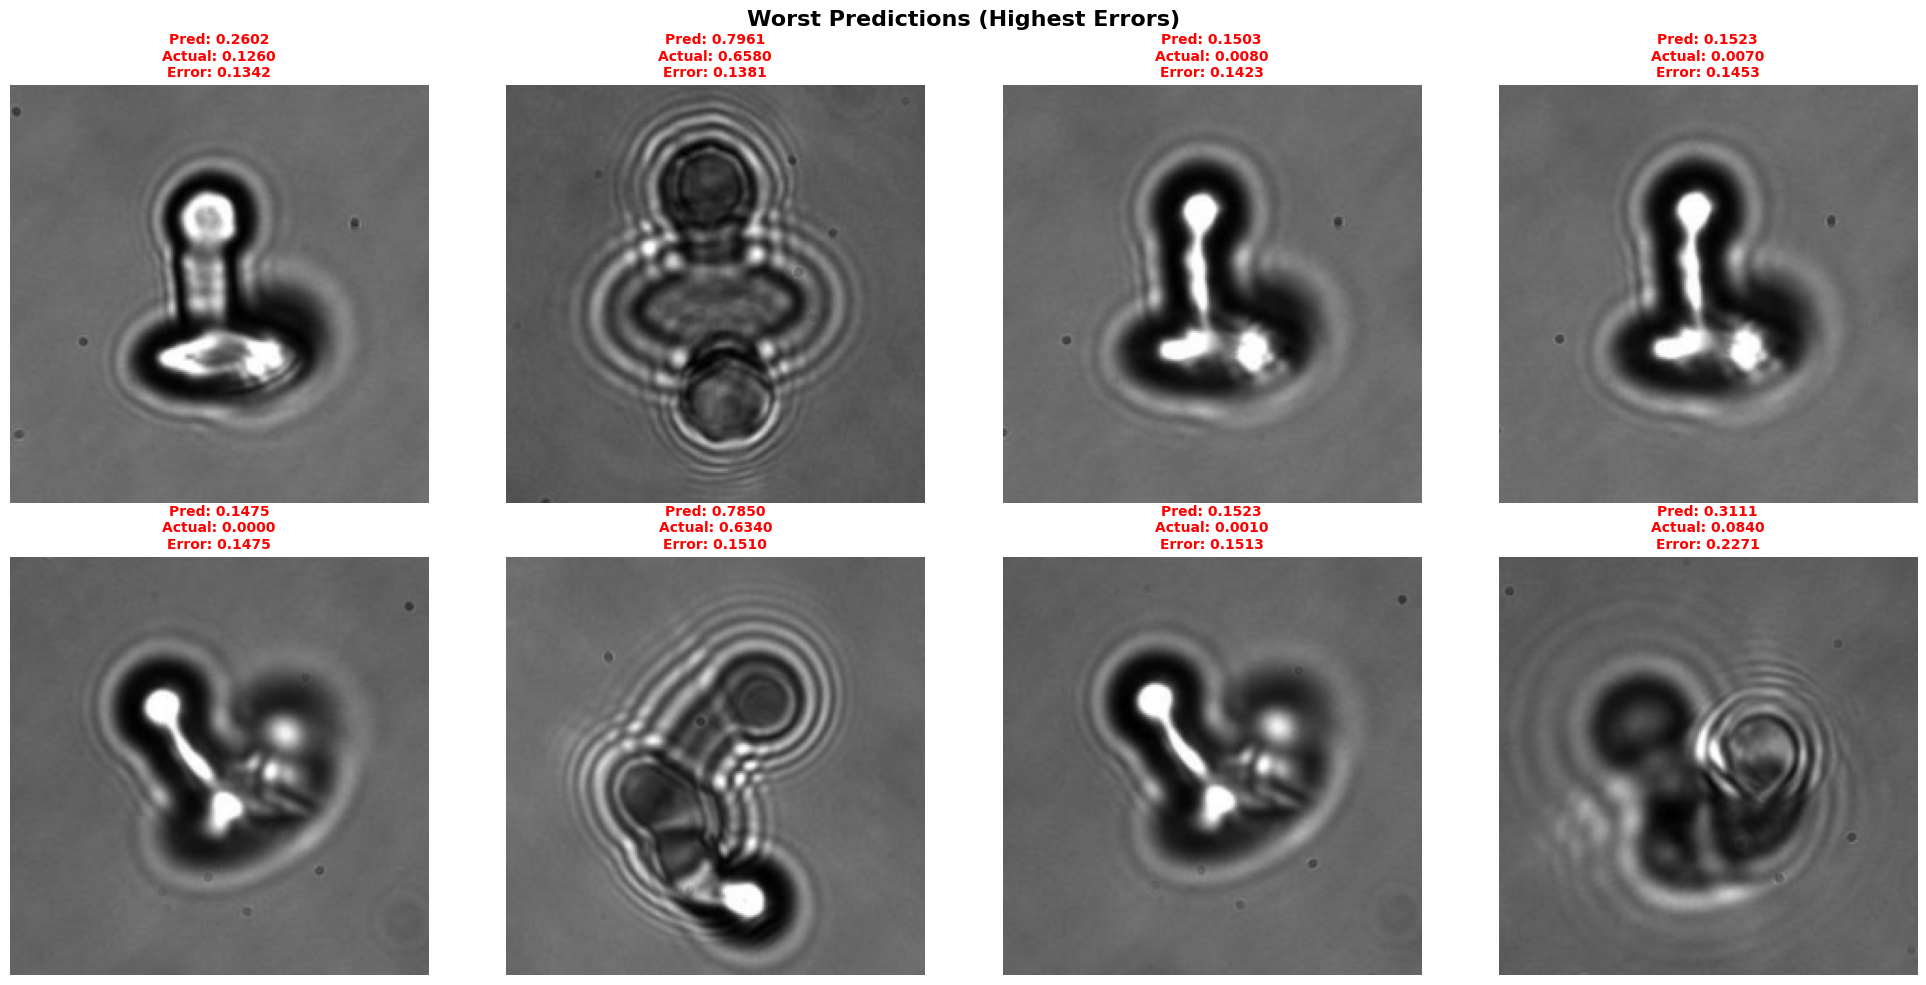

In [22]:
# Visualize worst predictions
fig, axes = plt.subplots(2, 4, figsize=(20, 10))
axes = axes.flatten()

for i, idx in enumerate(worst_indices):
    img = test_results['images'][idx]
    pred = test_results['predictions'][idx]
    target = test_results['targets'][idx]
    error = pred - target
    
    # Denormalize image
    img_display = img.transpose(1, 2, 0)
    img_display = (img_display - img_display.min()) / (img_display.max() - img_display.min())
    
    axes[i].imshow(img_display)
    axes[i].axis('off')
    axes[i].set_title(
        f'Pred: {pred:.4f}\nActual: {target:.4f}\nError: {error:.4f}',
        fontsize=10,
        fontweight='bold',
        color='red'
    )

plt.suptitle(f'{final_model_name} - Worst Predictions (Highest Errors)', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.savefig(reports_dir / f'{MODEL_PREFIX}_worst_predictions.png', dpi=300, bbox_inches='tight')
plt.show()

### 8.3 Error Analysis by Depth Range

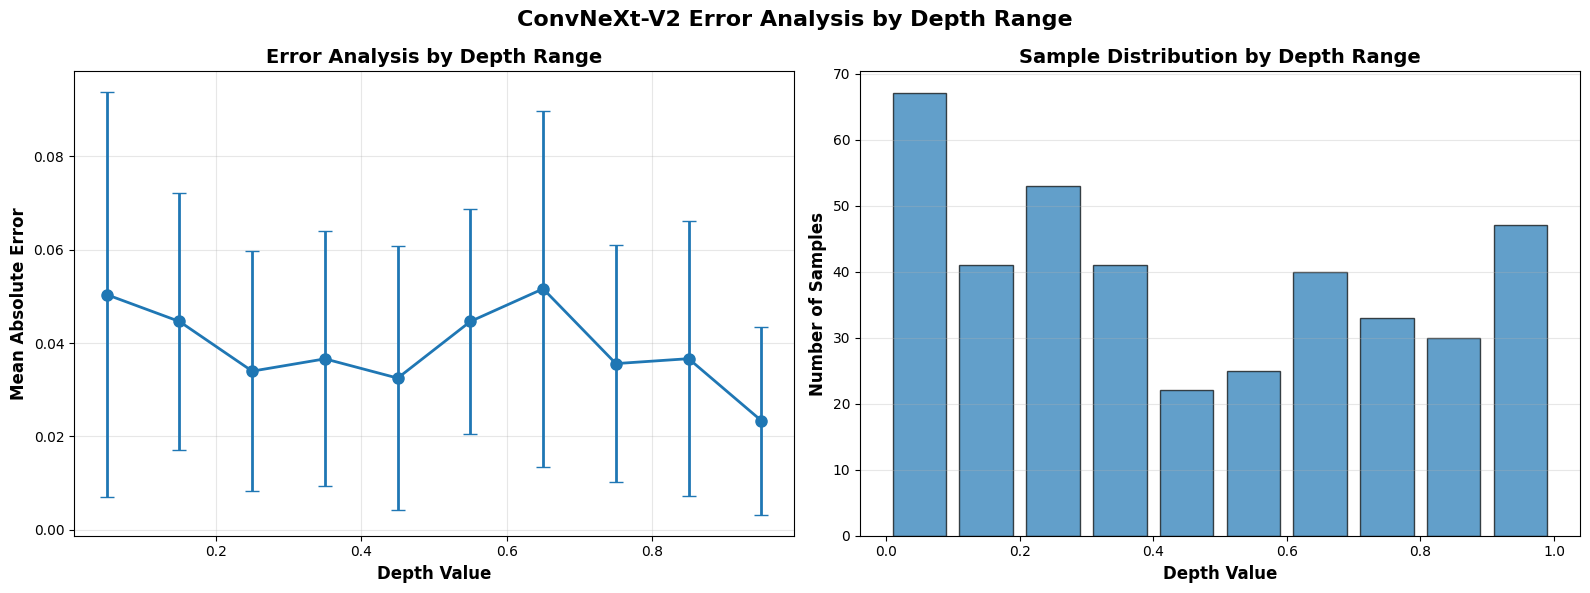

In [23]:
# Analyze errors by depth range
targets = test_results['targets']
predictions = test_results['predictions']
abs_errors = np.abs(predictions - targets)

# Create depth bins
num_bins = 10
depth_bins = np.linspace(targets.min(), targets.max(), num_bins + 1)
bin_indices = np.digitize(targets, depth_bins) - 1

# Calculate statistics per bin
bin_centers = []
bin_mean_errors = []
bin_std_errors = []
bin_counts = []

for i in range(num_bins):
    mask = bin_indices == i
    if np.sum(mask) > 0:
        bin_centers.append((depth_bins[i] + depth_bins[i+1]) / 2)
        bin_mean_errors.append(np.mean(abs_errors[mask]))
        bin_std_errors.append(np.std(abs_errors[mask]))
        bin_counts.append(np.sum(mask))

# Plot error analysis
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Error vs depth range
axes[0].errorbar(bin_centers, bin_mean_errors, yerr=bin_std_errors,
                 marker='o', markersize=8, capsize=5, linewidth=2)
axes[0].set_xlabel('Depth Value', fontweight='bold', fontsize=12)
axes[0].set_ylabel('Mean Absolute Error', fontweight='bold', fontsize=12)
axes[0].set_title('Error Analysis by Depth Range', fontsize=14, fontweight='bold')
axes[0].grid(alpha=0.3)

# Sample distribution by depth range
axes[1].bar(bin_centers, bin_counts, width=(depth_bins[1]-depth_bins[0])*0.8,
            alpha=0.7, edgecolor='black')
axes[1].set_xlabel('Depth Value', fontweight='bold', fontsize=12)
axes[1].set_ylabel('Number of Samples', fontweight='bold', fontsize=12)
axes[1].set_title('Sample Distribution by Depth Range', fontsize=14, fontweight='bold')
axes[1].grid(alpha=0.3, axis='y')

plt.suptitle('ConvNeXt-V2 Error Analysis by Depth Range', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.savefig(reports_dir / '8_convnext_v2_depth_error_by_range.png', dpi=300, bbox_inches='tight')
plt.show()

### 8.4 Feature Map Visualization

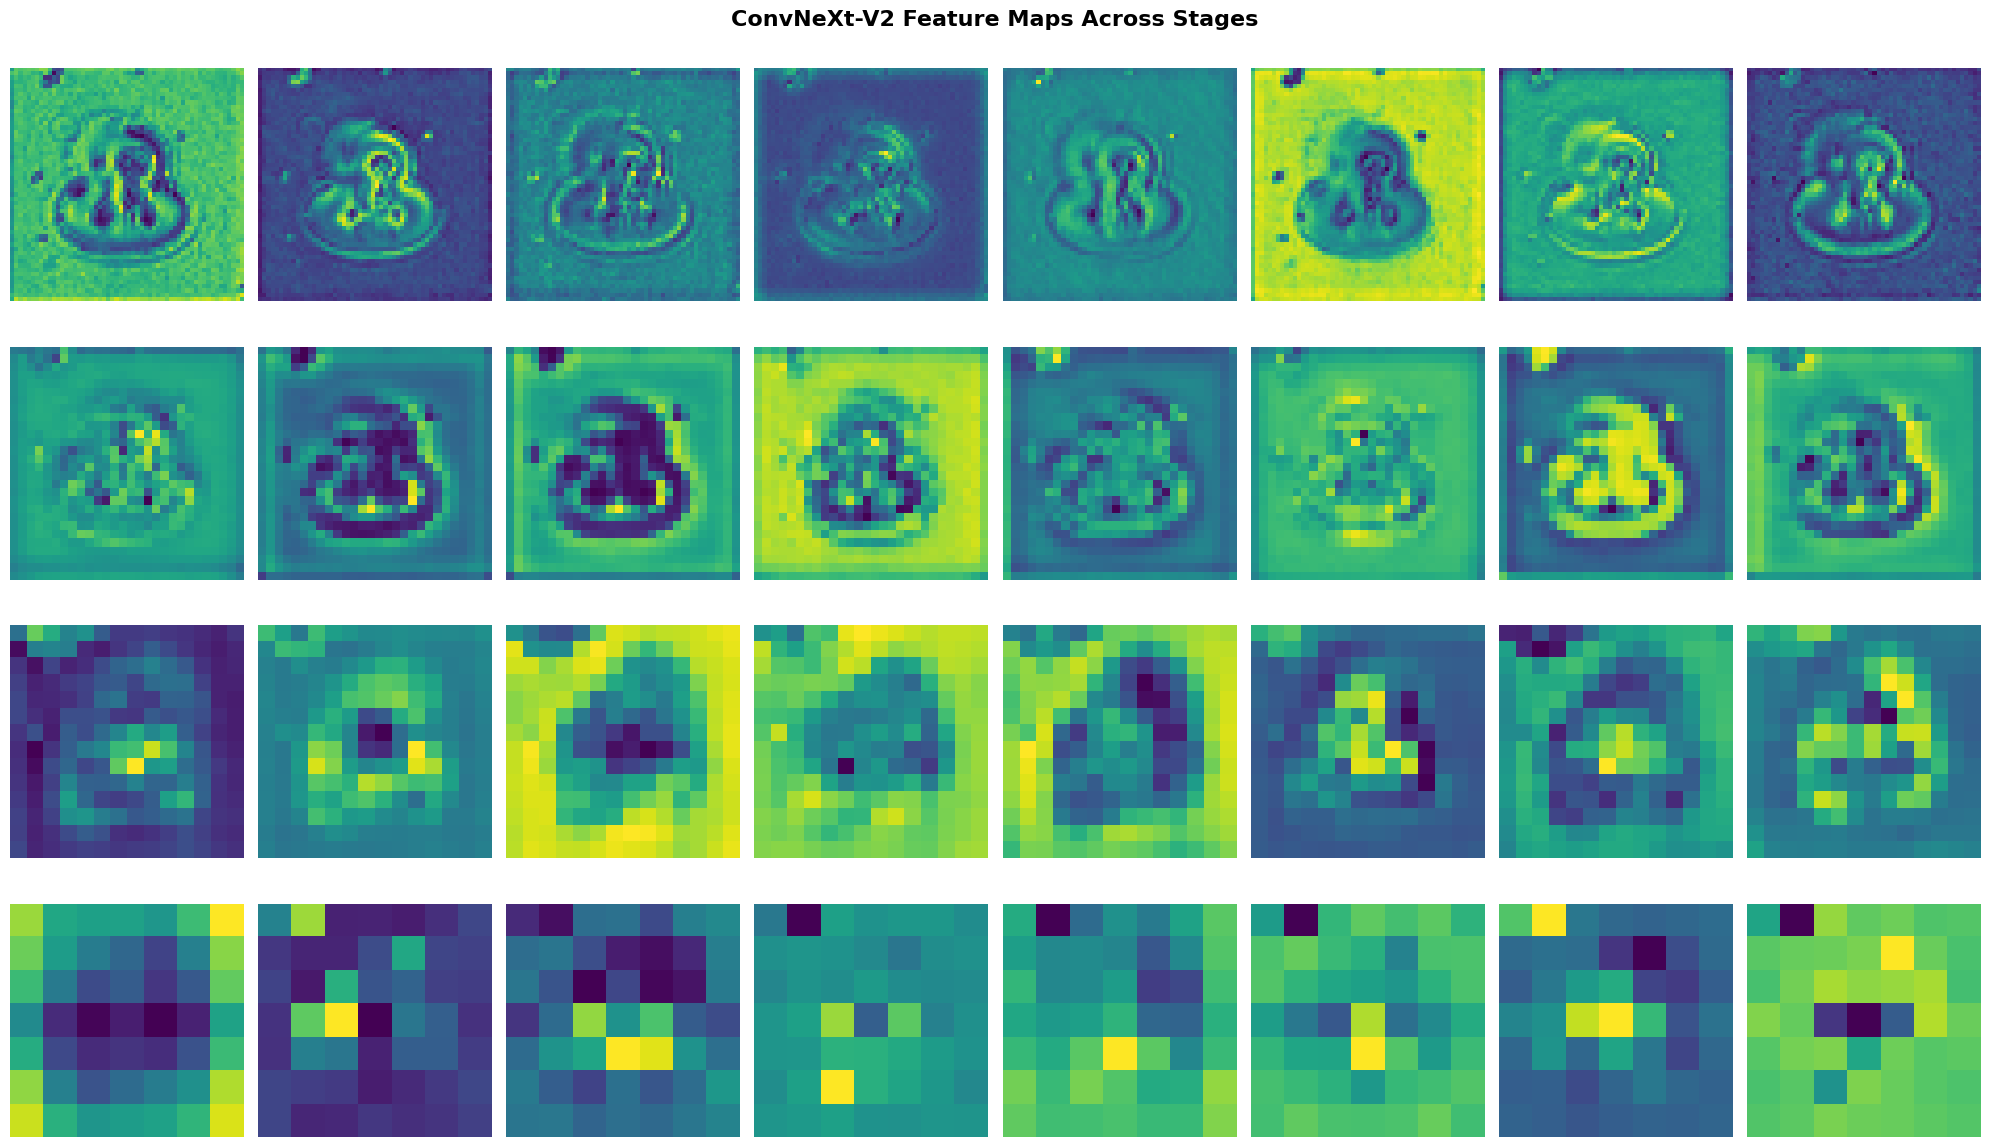

In [24]:
# Get a sample image
sample_idx = 0
sample_img = test_results['images'][sample_idx:sample_idx+1]
sample_img_tensor = torch.from_numpy(sample_img).to(device)

# Extract feature maps from ConvNeXt-V2 stages
model.eval()
activations = []

def get_activation(name):
    def hook(module, input, output):
        activations.append(output.detach())
    return hook

# Register hooks for ConvNeXt-V2 stages
hooks = []
for i in range(4):  # ConvNeXt-V2 has 4 stages
    hook = model.backbone.stages[i].register_forward_hook(get_activation(f'stage{i}'))
    hooks.append(hook)

# Forward pass
with torch.no_grad():
    _ = model(sample_img_tensor)

# Remove hooks
for hook in hooks:
    hook.remove()

# Visualize feature maps from each stage
fig = plt.figure(figsize=(20, 12))
num_stages = len(activations)

for stage_idx in range(num_stages):
    activation = activations[stage_idx][0].cpu().numpy()  # First sample
    num_channels = min(8, activation.shape[0])  # Show max 8 channels
    
    for ch_idx in range(num_channels):
        ax = plt.subplot(num_stages, 8, stage_idx * 8 + ch_idx + 1)
        
        # Handle different spatial sizes
        if len(activation.shape) == 3:
            feature_map = activation[ch_idx]
        else:
            feature_map = activation[ch_idx].mean(axis=0)
        
        ax.imshow(feature_map, cmap='viridis')
        ax.axis('off')
        if ch_idx == 0:
            ax.set_ylabel(f'Stage {stage_idx+1}', fontweight='bold', fontsize=10)

plt.suptitle('ConvNeXt-V2 Feature Maps Across Stages', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.savefig(reports_dir / '8_convnext_v2_depth_feature_maps.png', dpi=300, bbox_inches='tight')
plt.show()

### 8.5 Grad-CAM for Regression

Visualize which regions the model focuses on for depth prediction.

In [25]:
def generate_gradcam_regression(model, img_tensor, target_layer):
    """
    Generate Grad-CAM heatmap for regression model
    
    Args:
        model: Regression model
        img_tensor: Input image tensor (1, C, H, W)
        target_layer: Layer to generate CAM from
    
    Returns:
        heatmap: Grad-CAM heatmap
    """
    model.eval()
    
    # Forward pass and get activations
    activations = []
    gradients = []
    
    def forward_hook(module, input, output):
        activations.append(output)
    
    def backward_hook(module, grad_input, grad_output):
        gradients.append(grad_output[0])
    
    # Register hooks
    handle_forward = target_layer.register_forward_hook(forward_hook)
    handle_backward = target_layer.register_full_backward_hook(backward_hook)
    
    # Forward pass
    img_tensor.requires_grad_(True)
    output = model(img_tensor)
    
    # Backward pass (maximize output for regression)
    model.zero_grad()
    output.backward()
    
    # Remove hooks
    handle_forward.remove()
    handle_backward.remove()
    
    # Get gradients and activations
    grads = gradients[0].cpu().data.numpy()[0]
    acts = activations[0].cpu().data.numpy()[0]
    
    # Weight channels by gradient
    weights = np.mean(grads, axis=(1, 2))
    cam = np.zeros(acts.shape[1:], dtype=np.float32)
    
    for i, w in enumerate(weights):
        cam += w * acts[i]
    
    # Apply ReLU
    cam = np.maximum(cam, 0)
    
    # Normalize
    if cam.max() > 0:
        cam = cam / cam.max()
    
    return cam

print("Grad-CAM function defined")

Grad-CAM function defined


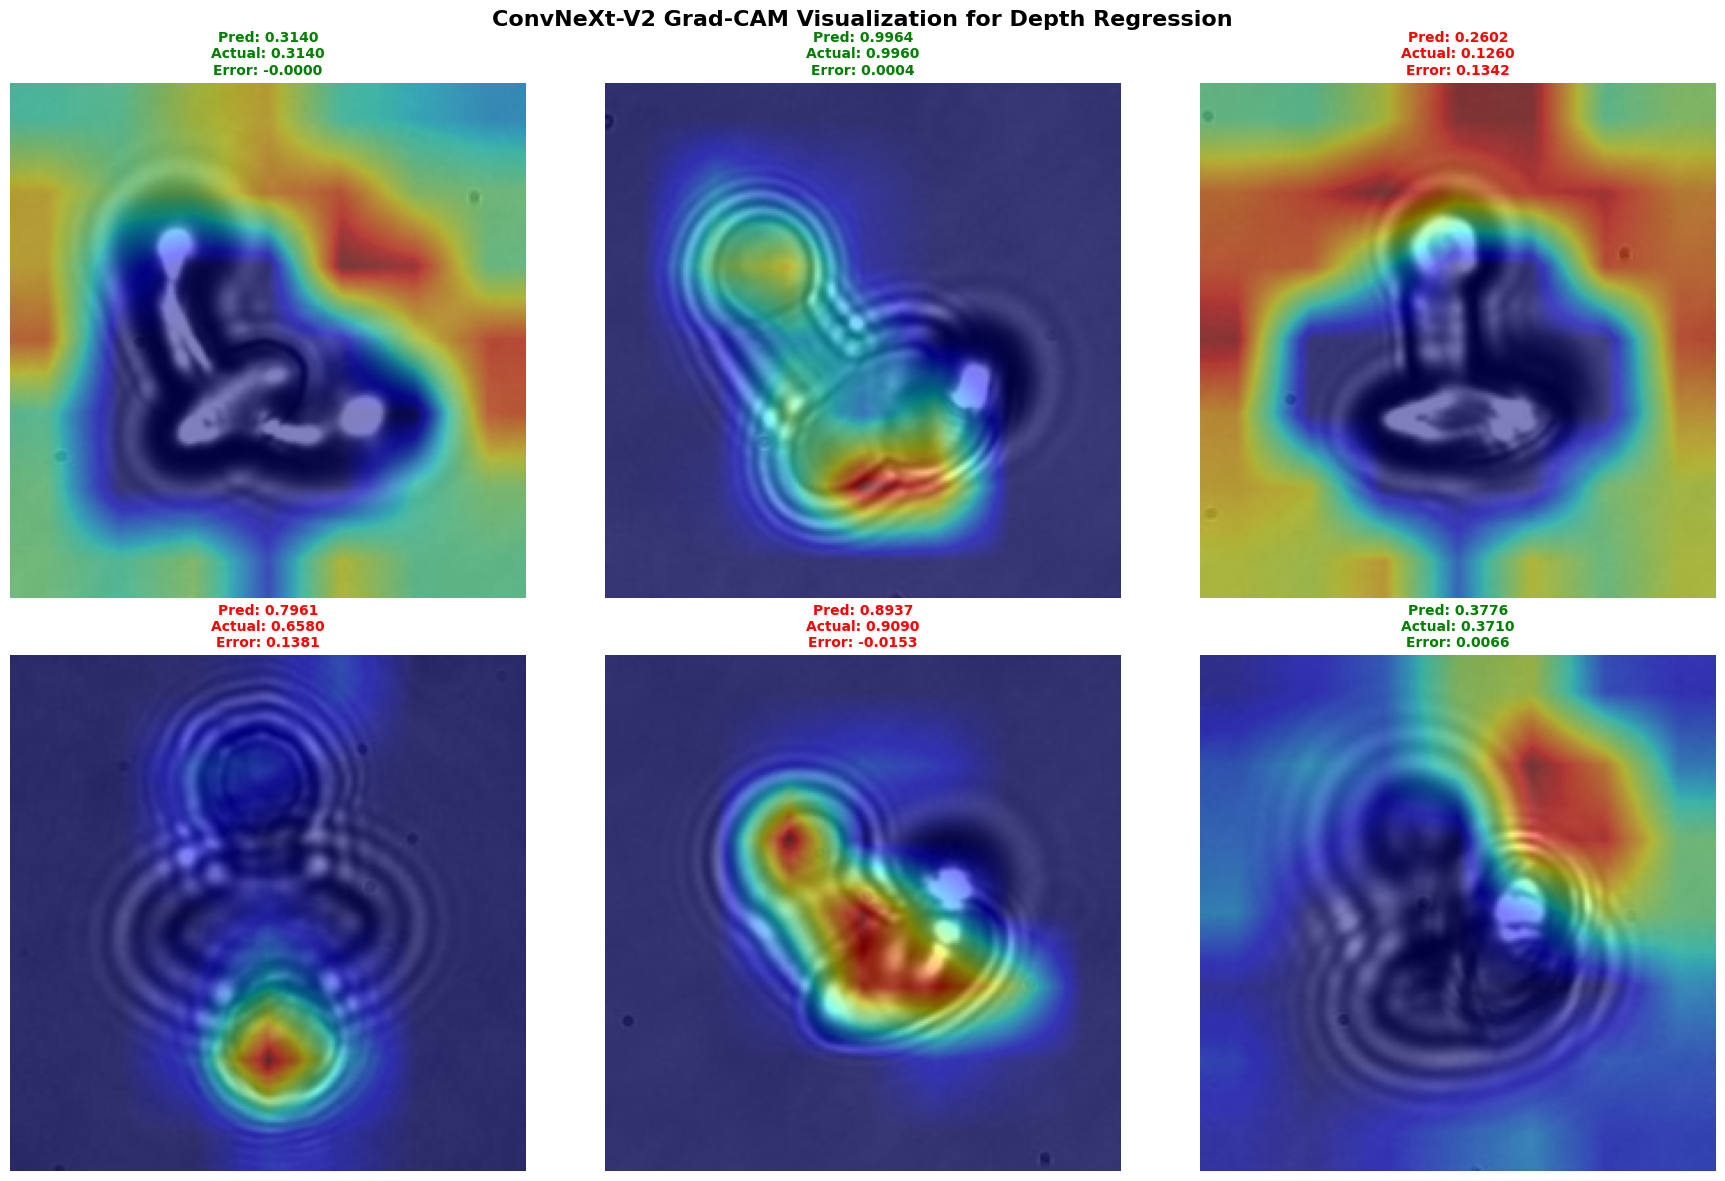

In [26]:
# Generate Grad-CAM for selected samples
# Select samples (best, worst, and random)
sample_indices = [
    best_indices[0],
    best_indices[1],
    worst_indices[0],
    worst_indices[1],
    np.random.randint(0, len(test_results['images'])),
    np.random.randint(0, len(test_results['images']))
]

fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.flatten()

# Use last stage of ConvNeXt-V2
target_layer = model.backbone.stages[-1]

for i, idx in enumerate(sample_indices):
    # Get image
    img = test_results['images'][idx]
    img_tensor = torch.from_numpy(img[np.newaxis, :]).to(device)
    
    # Get prediction
    pred = test_results['predictions'][idx]
    target = test_results['targets'][idx]
    error = pred - target
    
    # Generate Grad-CAM
    heatmap = generate_gradcam_regression(model, img_tensor, target_layer)
    
    # Resize heatmap to image size
    heatmap_resized = cv2.resize(heatmap, (224, 224))
    
    # Denormalize image
    img_display = img.transpose(1, 2, 0)
    img_display = (img_display - img_display.min()) / (img_display.max() - img_display.min())
    
    # Overlay heatmap
    axes[i].imshow(img_display)
    axes[i].imshow(heatmap_resized, cmap='jet', alpha=0.5)
    axes[i].axis('off')
    
    # Color based on error
    color = 'green' if abs(error) < 0.01 else 'red'
    axes[i].set_title(
        f'Pred: {pred:.4f}\nActual: {target:.4f}\nError: {error:.4f}',
        fontsize=10,
        fontweight='bold',
        color=color
    )

plt.suptitle('ConvNeXt-V2 Grad-CAM Visualization for Depth Regression', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.savefig(reports_dir / '8_convnext_v2_depth_gradcam.png', dpi=300, bbox_inches='tight')
plt.show()

### 8.6 Transfer Learning Feature Analysis

In [27]:
# Analyze what features from classification help with depth estimation
# Extract features from multiple samples
model.eval()
features_list = []
depth_list = []

with torch.no_grad():
    for i in range(min(100, len(test_results['images']))):
        img = test_results['images'][i:i+1]
        img_tensor = torch.from_numpy(img).to(device)
        _, features = model(img_tensor, return_features=True)
        features_list.append(features.cpu().numpy())
        depth_list.append(test_results['targets'][i])

features_array = np.concatenate(features_list, axis=0)
depth_array = np.array(depth_list)

print(f"Extracted features shape: {features_array.shape}")
print(f"Depth values shape: {depth_array.shape}")

Extracted features shape: (100, 768)
Depth values shape: (100,)


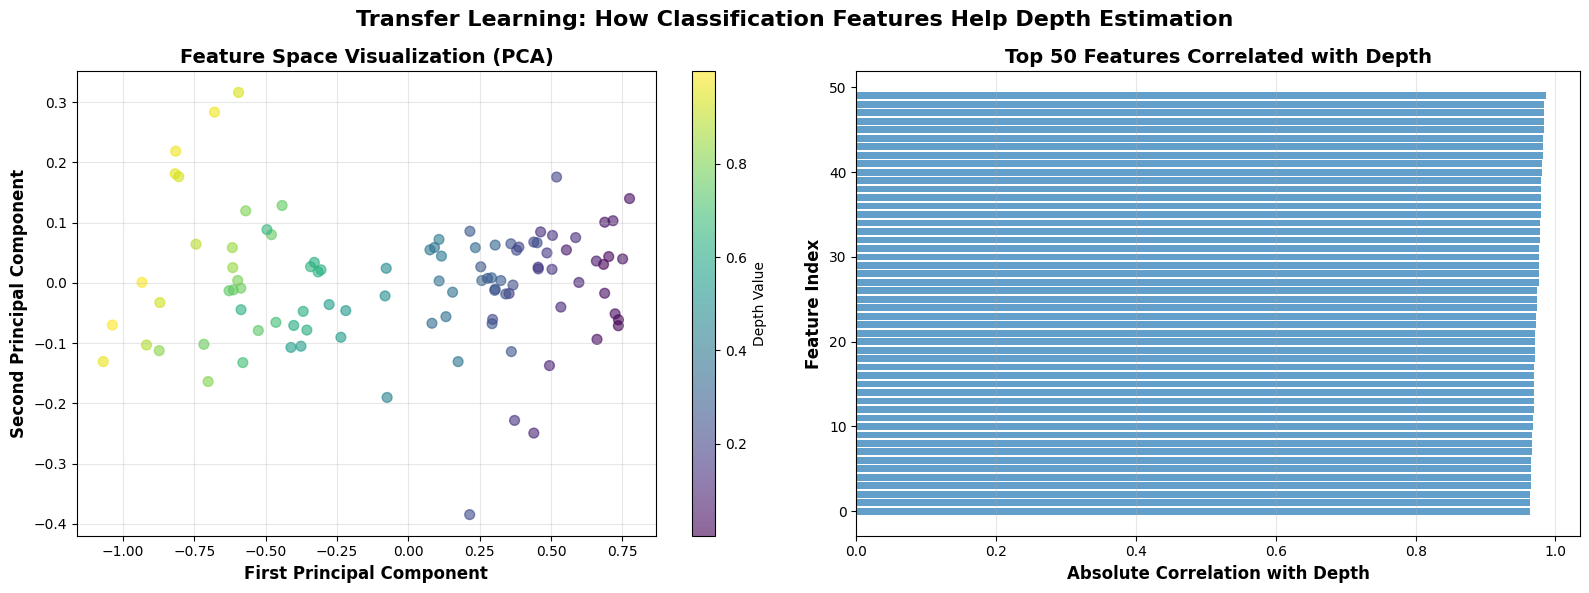


Feature Analysis:
   Total features: 768
   Mean abs correlation: 0.7258
   Max abs correlation: 0.9858
   Features with |corr| > 0.3: 698


In [28]:
# Visualize feature-depth correlation
from sklearn.decomposition import PCA

# Apply PCA to reduce feature dimensionality
pca = PCA(n_components=2)
features_2d = pca.fit_transform(features_array)

# Plot features colored by depth
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# PCA visualization colored by depth
scatter = axes[0].scatter(features_2d[:, 0], features_2d[:, 1], 
                          c=depth_array, cmap='viridis', s=50, alpha=0.6)
axes[0].set_xlabel('First Principal Component', fontweight='bold', fontsize=12)
axes[0].set_ylabel('Second Principal Component', fontweight='bold', fontsize=12)
axes[0].set_title('Feature Space Visualization (PCA)', fontsize=14, fontweight='bold')
plt.colorbar(scatter, ax=axes[0], label='Depth Value')
axes[0].grid(alpha=0.3)

# Feature correlation with depth
feature_correlations = []
for i in range(features_array.shape[1]):
    corr = np.corrcoef(features_array[:, i], depth_array)[0, 1]
    feature_correlations.append(abs(corr))

# Plot top correlations
top_k = 50
top_indices = np.argsort(feature_correlations)[-top_k:]
axes[1].barh(range(top_k), [feature_correlations[i] for i in top_indices], alpha=0.7)
axes[1].set_xlabel('Absolute Correlation with Depth', fontweight='bold', fontsize=12)
axes[1].set_ylabel('Feature Index', fontweight='bold', fontsize=12)
axes[1].set_title(f'Top {top_k} Features Correlated with Depth', fontsize=14, fontweight='bold')
axes[1].grid(alpha=0.3, axis='x')

plt.suptitle('Transfer Learning: How Classification Features Help Depth Estimation', 
             fontsize=16, fontweight='bold')
plt.tight_layout()
plt.savefig(reports_dir / '8_convnext_v2_depth_feature_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"\nFeature Analysis:")
print(f"   Total features: {features_array.shape[1]}")
print(f"   Mean abs correlation: {np.mean(feature_correlations):.4f}")
print(f"   Max abs correlation: {np.max(feature_correlations):.4f}")
print(f"   Features with |corr| > 0.3: {sum(c > 0.3 for c in feature_correlations)}")

### 8.7 t-SNE Embedding Space Colored by Depth

Visualize the learned feature embeddings in 2D using t-SNE, colored by continuous depth values to see how the model clusters samples by depth.

Extracting features from all test samples for t-SNE...
Total features shape: (400, 768)
Total depth values: 400
Depth range: [0.000, 1.000]

Applying t-SNE (this may take a minute)...
t-SNE completed!


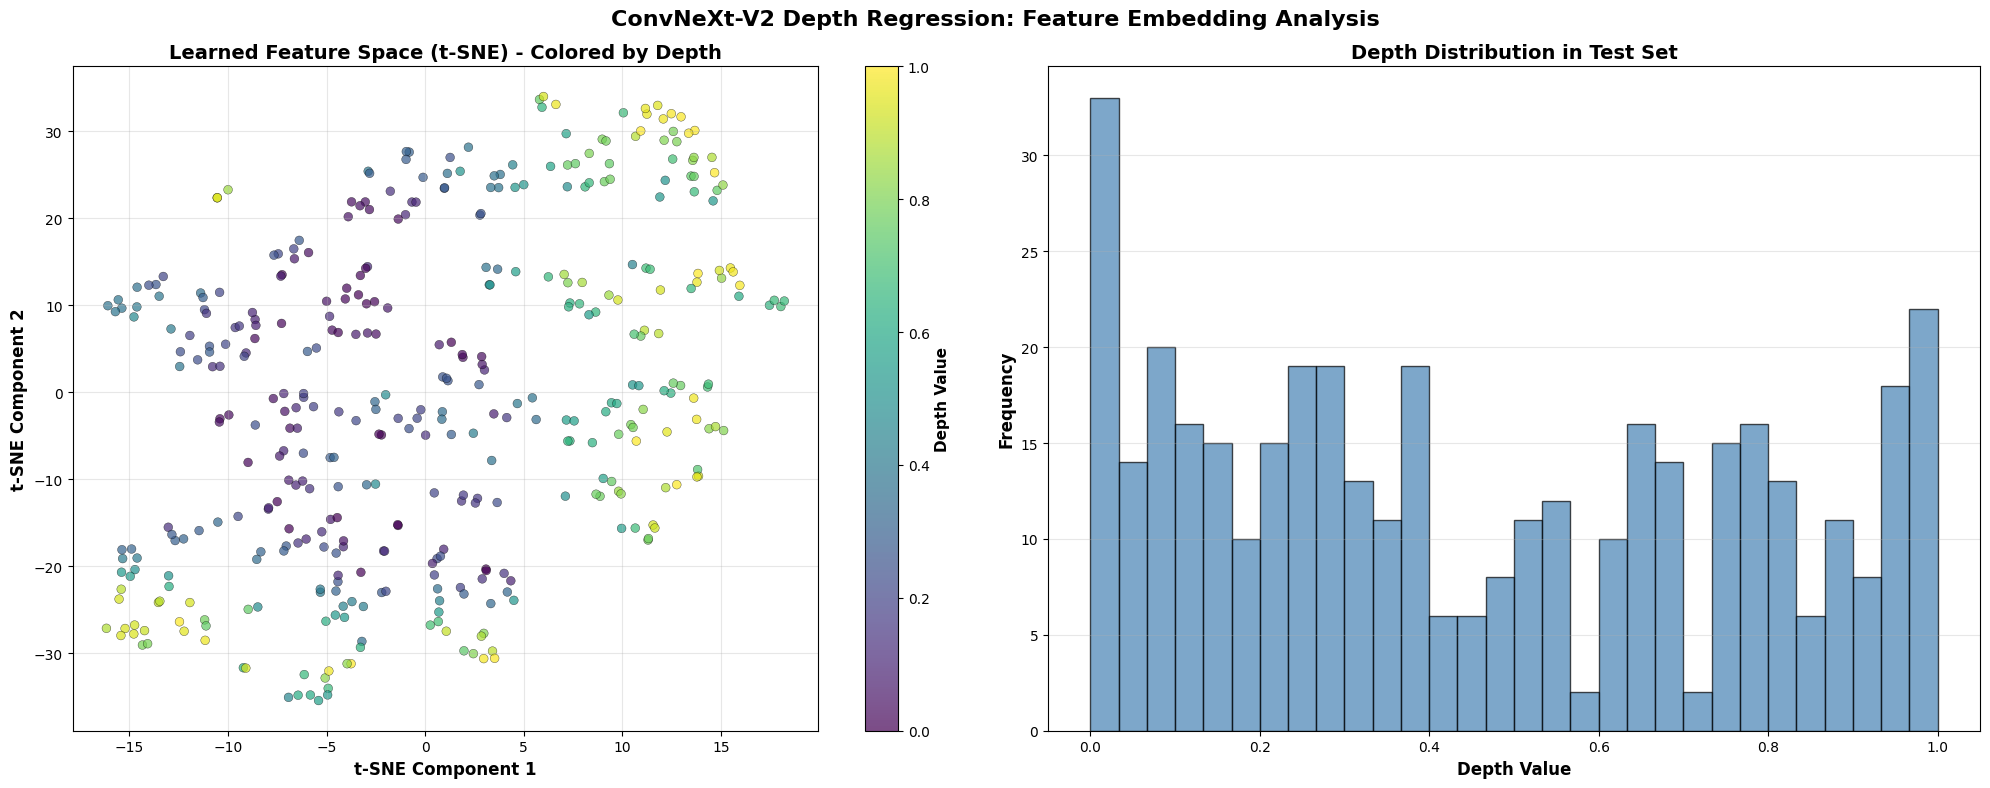


 t-SNE visualization saved to: reports/8_convnext_v2_depth_tsne_by_depth.png

t-SNE Analysis:
   Correlation (Component 1 vs Depth): 0.4670
   Correlation (Component 2 vs Depth): 0.0169
   Max correlation: 0.4670
   → Moderate correlation: Features capture some depth information


In [18]:
# Extract features from ALL test samples for t-SNE
print("Extracting features from all test samples for t-SNE...")

model.eval()
all_features_list = []
all_depth_list = []

with torch.no_grad():
    for images, depths in test_loader:
        images = images.to(device)
        _, features = model(images, return_features=True)
        all_features_list.append(features.cpu().numpy())
        all_depth_list.append(depths.numpy())

# Concatenate all batches
all_features = np.concatenate(all_features_list, axis=0)
all_depths = np.concatenate(all_depth_list, axis=0)

print(f"Total features shape: {all_features.shape}")
print(f"Total depth values: {len(all_depths)}")
print(f"Depth range: [{all_depths.min():.3f}, {all_depths.max():.3f}]")

# Apply t-SNE
from sklearn.manifold import TSNE

print("\nApplying t-SNE (this may take a minute)...")
tsne = TSNE(n_components=2, random_state=42, perplexity=30, n_iter=1000)
features_tsne = tsne.fit_transform(all_features)

print("t-SNE completed!")

# Create visualization
fig, axes = plt.subplots(1, 2, figsize=(20, 8))

# 2D t-SNE colored by depth
scatter = axes[0].scatter(
    features_tsne[:, 0],
    features_tsne[:, 1],
    c=all_depths,
    cmap='viridis',
    s=40,
    alpha=0.7,
    edgecolors='k',
    linewidth=0.3
)
axes[0].set_xlabel('t-SNE Component 1', fontweight='bold', fontsize=12)
axes[0].set_ylabel('t-SNE Component 2', fontweight='bold', fontsize=12)
axes[0].set_title('Learned Feature Space (t-SNE) - Colored by Depth', fontsize=14, fontweight='bold')
cbar = plt.colorbar(scatter, ax=axes[0])
cbar.set_label('Depth Value', fontweight='bold', fontsize=11)
axes[0].grid(alpha=0.3)

# Histogram of depth distribution
axes[1].hist(all_depths, bins=30, alpha=0.7, color='steelblue', edgecolor='black')
axes[1].set_xlabel('Depth Value', fontweight='bold', fontsize=12)
axes[1].set_ylabel('Frequency', fontweight='bold', fontsize=12)
axes[1].set_title('Depth Distribution in Test Set', fontsize=14, fontweight='bold')
axes[1].grid(alpha=0.3, axis='y')

plt.suptitle('ConvNeXt-V2 Depth Regression: Feature Embedding Analysis', 
             fontsize=16, fontweight='bold')
plt.tight_layout()
plt.savefig(project_root / 'reports' / '8_convnext_v2_depth_tsne_by_depth.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"\n t-SNE visualization saved to: reports/8_convnext_v2_depth_tsne_by_depth.png")

# Additional analysis: correlation between t-SNE components and depth
corr_comp1 = np.corrcoef(features_tsne[:, 0], all_depths)[0, 1]
corr_comp2 = np.corrcoef(features_tsne[:, 1], all_depths)[0, 1]

print(f"\nt-SNE Analysis:")
print(f"   Correlation (Component 1 vs Depth): {corr_comp1:.4f}")
print(f"   Correlation (Component 2 vs Depth): {corr_comp2:.4f}")
print(f"   Max correlation: {max(abs(corr_comp1), abs(corr_comp2)):.4f}")

if max(abs(corr_comp1), abs(corr_comp2)) > 0.5:
    print("   → Strong correlation: The model learns depth-aware feature representations!")
elif max(abs(corr_comp1), abs(corr_comp2)) > 0.3:
    print("   → Moderate correlation: Features capture some depth information")
else:
    print("   → Weak correlation: Features may be more complex/non-linear")

Computing 3D t-SNE for enhanced visualization...
3D t-SNE completed!


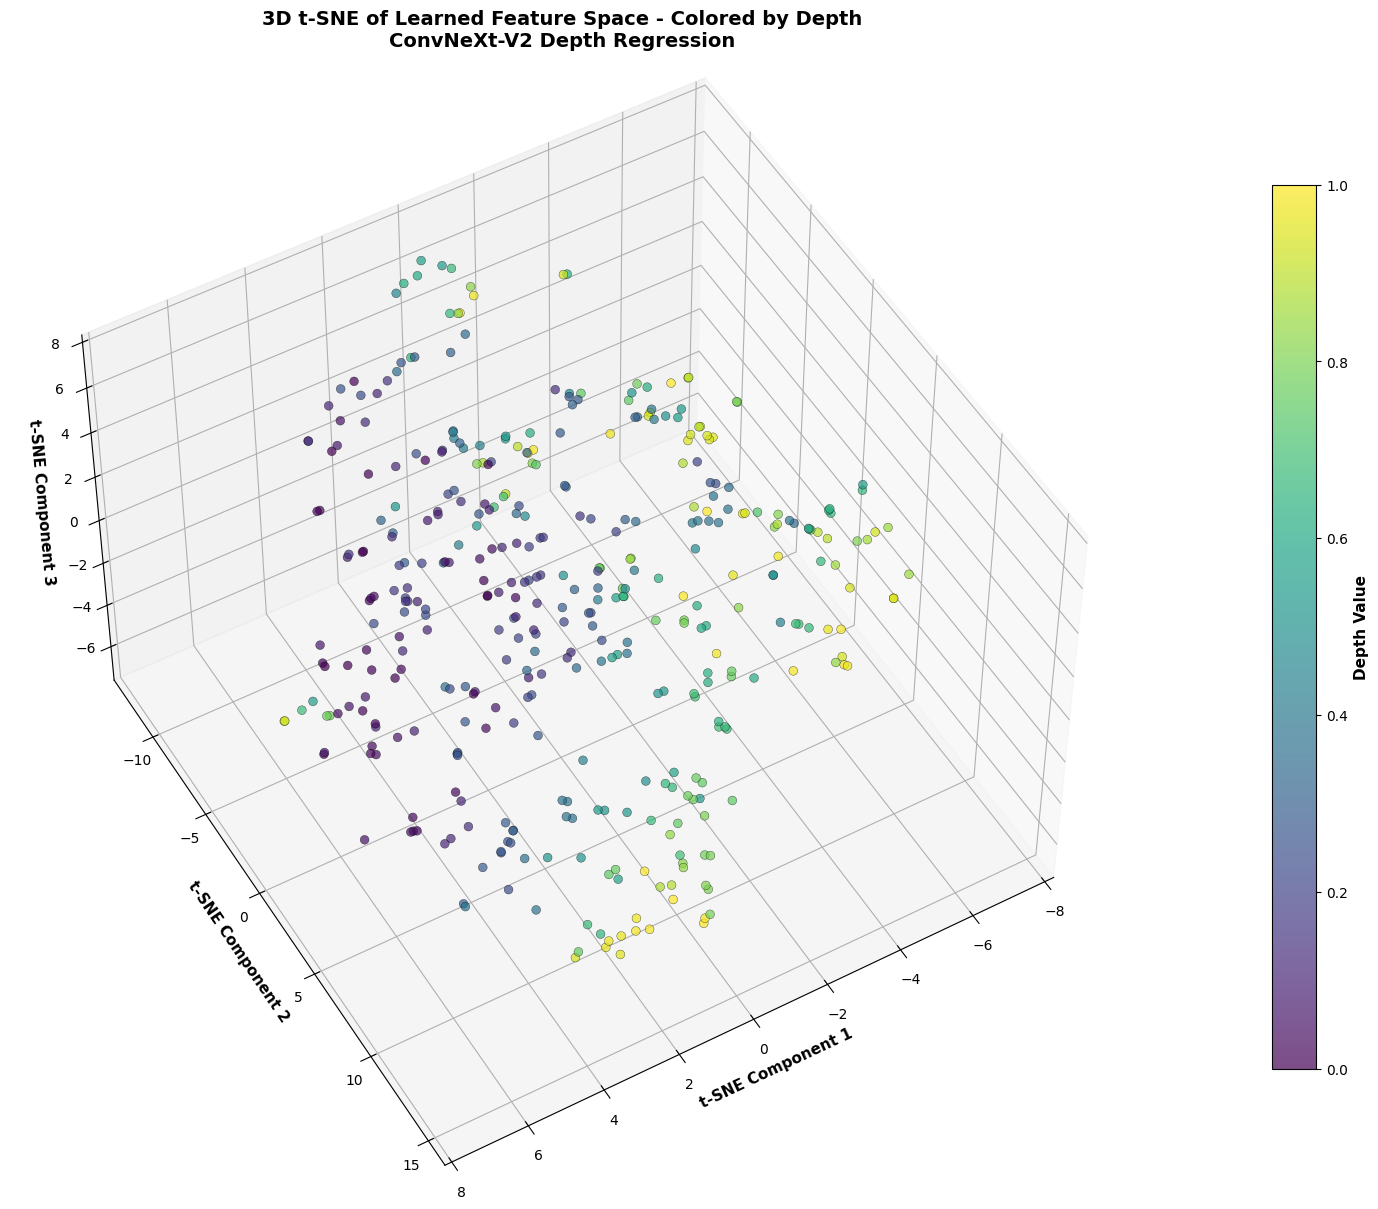


✅ 3D t-SNE visualization saved to: reports/8_convnext_v2_depth_tsne_3d_by_depth.png

3D t-SNE Depth Correlations:
   Component 1: -0.6752
   Component 2: 0.0824
   Component 3: -0.4821
   → Strongest: Component 1 (r = -0.6752)


In [27]:
# 3D t-SNE visualization
print("Computing 3D t-SNE for enhanced visualization...")

tsne_3d = TSNE(n_components=3, random_state=42, perplexity=30, n_iter=1000)
features_tsne_3d = tsne_3d.fit_transform(all_features)

print("3D t-SNE completed!")

# Create 3D visualization
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(16, 12))
ax = fig.add_subplot(111, projection='3d')

# Scatter plot colored by depth
scatter = ax.scatter(
    features_tsne_3d[:, 0],
    features_tsne_3d[:, 1],
    features_tsne_3d[:, 2],
    c=all_depths,
    cmap='viridis',
    s=40,
    alpha=0.7,
    edgecolors='k',
    linewidth=0.3
)

# Labels and title
ax.set_xlabel('t-SNE Component 1', fontweight='bold', fontsize=11)
ax.set_ylabel('t-SNE Component 2', fontweight='bold', fontsize=11)
ax.set_zlabel('t-SNE Component 3', fontweight='bold', fontsize=11)
ax.set_title('3D t-SNE of Learned Feature Space - Colored by Depth\nConvNeXt-V2 Depth Regression', 
             fontsize=14, fontweight='bold', pad=20)

# Add colorbar
cbar = plt.colorbar(scatter, ax=ax, pad=0.1, shrink=0.8)
cbar.set_label('Depth Value', fontweight='bold', fontsize=11)

# Set viewing angle
ax.view_init(elev=50, azim=60)
ax.grid(alpha=0.3)

plt.tight_layout()
plt.savefig(project_root / 'reports' / '8_convnext_v2_depth_tsne_3d_by_depth.png', dpi=200, bbox_inches='tight')
plt.show()

print(f"\n✅ 3D t-SNE visualization saved to: reports/8_convnext_v2_depth_tsne_3d_by_depth.png")

# Correlation analysis for 3D
corr_3d_comp1 = np.corrcoef(features_tsne_3d[:, 0], all_depths)[0, 1]
corr_3d_comp2 = np.corrcoef(features_tsne_3d[:, 1], all_depths)[0, 1]
corr_3d_comp3 = np.corrcoef(features_tsne_3d[:, 2], all_depths)[0, 1]

print(f"\n3D t-SNE Depth Correlations:")
print(f"   Component 1: {corr_3d_comp1:.4f}")
print(f"   Component 2: {corr_3d_comp2:.4f}")
print(f"   Component 3: {corr_3d_comp3:.4f}")

# Find which component has strongest correlation
max_corr_idx = np.argmax(np.abs([corr_3d_comp1, corr_3d_comp2, corr_3d_comp3]))
max_corr_val = [corr_3d_comp1, corr_3d_comp2, corr_3d_comp3][max_corr_idx]
print(f"   → Strongest: Component {max_corr_idx + 1} (r = {max_corr_val:.4f})")